In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import random
SEED = 10

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import seaborn as sns
# sns.set_theme()
# sns.set(font_scale=2)

import datajoint as dj
dj.config['database.host'] = 'datajoint.mesoscale-activity-map.org'
dj.config['database.user'] = 'pochen'
dj.config['database.password'] = 'simple'

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util

Connecting pochen@datajoint.mesoscale-activity-map.org:3306


# Plan
### Fetch population data
### Coding direction analysis
### dsPCA




## Fetch population data

In [2]:
# after unit qc
foraging_session = experiment.Session & 'username = "hh"'
all_unit_qc = (ephys.Unit * ephys.ClusterMetric * ephys.UnitStat) & foraging_session & 'presence_ratio > 0.95' & 'amplitude_cutoff < 0.1' & 'isi_violation < 0.5' & 'unit_amp > 70'
dj.U('annotation').aggr(((ephys.Unit & all_unit_qc.proj()) * histology.ElectrodeCCFPosition.ElectrodePosition) * ccf.CCFAnnotation, count='count(*)').fetch(format='frame', order_by='count desc')[:]

count
annotation                                              
Lateral septal nucleus, rostral (rostroventral)...   801
Caudoputamen                                         473
Secondary motor area, layer 6a                       401
Secondary motor area, layer 5                        294
Prelimbic area, layer 5                              286
...                                                  ...
Ethmoid nucleus of the thalamus                        1
Retrosplenial area, ventral part, layer 6a             1
Triangular nucleus of septum                           1
Prelimbic area, layer 6b                               1
Midbrain                                               1

[113 rows x 1 columns]

In [3]:
lab.WaterRestriction() & 'water_restriction_number LIKE "HH%"'

*subject_id    water_restrict cage_number    wr_start_date  wr_start_weigh
+------------+ +------------+ +------------+ +------------+ +------------+
472184         HH07           176952         2020-08-24     30.000        
472195         HH01           176954         2020-07-29     28.300        
473359         HH06           177549         2020-08-24     27.100        
473360         HH08           177549         2020-10-20     25.700        
473361         HH09           177549         2020-10-20     25.600        
473611         HH04           177643         2020-08-11     18.600        
482350         HH11           182525         2020-11-19     25.400        
482352         HH12           187449         2021-06-08     37.300        
482353         HH13           187450         2021-06-08     32.400        
482354         HH10           182526         2020-11-19     19.300        
490931         HH14           187214         2021-10-22     30.100        
490932         HH15           187214         2021-10-22     27.700        
   ...
 (Total: 15)

In [4]:
# select units
def select_unit_qc_region(all_unit_qc, region="Prelimbic%"):
    return (all_unit_qc * histology.ElectrodeCCFPosition.ElectrodePosition * ccf.CCFAnnotation) & 'annotation LIKE "{}"'.format(region)


def unique_session_in_region(unit_qc_region, region):
    print('total number of units in the region {}: {}'.format(region, len(unit_qc_region)))
    print(' unique sessions: {}'.format(np.unique(unit_qc_region.fetch('session'))))
    session_unit_cts = {}
    for session in np.unique(unit_qc_region.fetch('session')):
        session_unit_cts[session] = np.sum(unit_qc_region.fetch('session')==session)
        print(' session {}: {}'.format(session, np.sum(unit_qc_region.fetch('session')==session)))
    return session_unit_cts


def select_unit_qc_region_mouse_session(all_unit_qc, region="Prelimbic%", mouse="HH09", session=47):
    unit_qc_region = select_unit_qc_region(all_unit_qc, region=region)
    return unit_qc_region & (lab.WaterRestriction & 'water_restriction_number = "{}"'.format(mouse)) & 'session = {}'.format(session)


# fetch keys
def gen_keys2units(unit_qc_region_mouse_session):
    
    # get all keys
    keys2units = unit_qc_region_mouse_session.fetch('KEY')
    print('num of units: {}'.format(len(keys2units)))

    return keys2units


def gen_keys2trials(keys2units):
    
    # fetch trials in the session
    # print(psth_foraging.TrialCondition().fetch('trial_condition_name'))
    # psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    keys2trials_all = (psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units).fetch('KEY')
    trials_all = psth_foraging.TrialCondition().get_trials('foraging_LR_all_noearlylick') & keys2units
    print('num of all trials: {}'.format(len(keys2trials_all)))

    keys2trials_L = (psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units).fetch('KEY')
    trials_L = psth_foraging.TrialCondition().get_trials('foraging_L_all_noearlylick') & keys2units
    print('num of left trials: {}'.format(len(keys2trials_L)))

    keys2trials_R = (psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units).fetch('KEY')
    trials_R = psth_foraging.TrialCondition().get_trials('foraging_R_all_noearlylick') & keys2units
    print('num of right trials: {}'.format(len(keys2trials_R)))

    keys2trials_hit = (psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units).fetch('KEY')
    trials_hit = psth_foraging.TrialCondition().get_trials('foraging_LR_hit_noearlylick') & keys2units
    print('num of hit trials: {}'.format(len(keys2trials_hit)))

    keys2trials_miss = (psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units).fetch('KEY')
    trials_miss = psth_foraging.TrialCondition().get_trials('foraging_LR_miss_noearlylick') & keys2units
    print('num of miss trials: {}'.format(len(keys2trials_miss)))

    return [keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss]


# generate psth per trial
def gen_psth_per_trial(keys2units, trials, align_type):
    
    pop_psth_per_trial = []
    bins = None
    for key in keys2units:
        unit_psth_raster = psth_foraging.compute_unit_psth_and_raster(key, trials, align_type)
        unit_psth_per_trial = unit_psth_raster['psth_per_trial']  # (trial, time_step)
        pop_psth_per_trial.append(unit_psth_per_trial)
        if bins is None:
            bins = unit_psth_raster['bins']
    pop_psth_per_trial = np.array(pop_psth_per_trial)
    pop_psth_per_trial = np.moveaxis(pop_psth_per_trial, 1, -1)
    print('bins: {}'.format(bins.shape))
    print('population psth per trial: {}'.format(pop_psth_per_trial.shape))

    return bins, pop_psth_per_trial


def get_psth_by_trial_type_index(pop_psth, all_trial_ind, select_trial_ind):
    
    select_index = np.where(np.in1d(all_trial_ind, select_trial_ind))[0]
    pop_psth_selected_trial = pop_psth[:, :, select_index]
    print('check: sel trial ind {}, output pop psth {}'.format(select_trial_ind.shape, pop_psth_selected_trial.shape))
    
    return pop_psth_selected_trial

In [41]:
# fetch data from brain region
region_ann_lut = {
    'mPFC': "Prelimbic%",
    'ALM': "Secondary motor area%",
    'ACA': "Anterior cingulate area%",
    'RSP': "Lateral septal nucleus%",
    'olf': "%olfactory%",
    'ILA': "Infralimbic",
    'LSN': "Lateral septal nucleus%",
    'striatum': "striatum%",
    'CP': "Caudoputamen%",
    'NA': "Nucleus accumbens",
    'PAL': "Substantia innominata%"
}

# mPFC
# region, mouse, session = 'mPFC', "HH09", 47
# ALM
region, mouse, session = 'ALM', "HH09", 50
# ACA
# region, mouse, session = 'ACA', "HH09", 50
# RSP
# region, mouse, session = 'RSP', "HH09", 50
# olf
# region, mouse, session = 'olf', "HH09", 50
# ILA
# region, mouse, session = 'ILA', "HH09", 50

# LSN
# region, mouse, session ='LSN, "HH08", 50
# striatum
# region, mouse, session = 'striatum', "HH09", 50
# Caudoputamen
# region, mouse, session ="Caudoputamen", "HH13", 45
# NA
# region, mouse, session = 'NA', "HH09", 50
# PAL
# region, mouse, session = 'PAL', "HH09", 50


# select qc unit in region
unit_qc_region = select_unit_qc_region(all_unit_qc, region=region_ann_lut[region])
session_unit_cts = unique_session_in_region(unit_qc_region, region=region_ann_lut[region])

# select qc in region, by mouse and session
# subject_id = np.unique((unit_qc_region & 'session={}'.format(session)).fetch('subject_id'))
# if len(subject_id) == 1:
#     mouse = (lab.WaterRestriction() & 'subject_id={}'.format(subject_id[0])).fetch('water_restriction_number')[0]
#     print('mouse: {}'.format(mouse))
unit_qc_region_mouse_session = select_unit_qc_region_mouse_session(
                                    all_unit_qc, 
                                    region=region_ann_lut[region], 
                                    mouse=mouse, 
                                    session=session)
print('total number of units in {} by mouse {} by session {}: {}'.format(region, mouse, session, len(unit_qc_region_mouse_session)))

# fetch keys
keys2units = gen_keys2units(unit_qc_region_mouse_session)

# laterality
laterality_condition = {
        'right': 'ml_location > 0',
        'left': 'ml_location < 0'
}
ml_locations = np.unique((ephys.ProbeInsertion.InsertionLocation & keys2units).fetch('ml_location'))
hemi_choose = 'left'
if len(ml_locations) == 0:
    raise Exception('No ProbeInsertion.InsertionLocation available')
elif (ml_locations > 0).any() and (ml_locations < 0).any():
    print('The specified units belongs to both hemispheres, use pre-specified laterality')
    hemi = hemi_choose
    print(' manually choose laterality: {}'.format(hemi))
elif (ml_locations > 0).all():
    hemi = 'right'
elif (ml_locations < 0).all():
    hemi = 'left'
else:
    assert (ml_locations == 0).all()  # sanity check
    raise ValueError('Ambiguous hemisphere: ML locations are all 0...')

print('laterality: {}'.format(hemi))
keys_laterality = ephys.ProbeInsertion.InsertionLocation & keys2units & laterality_condition[hemi]
unit_qc_region_mouse_session_laterality = unit_qc_region_mouse_session & keys_laterality
keys2units = gen_keys2units(unit_qc_region_mouse_session_laterality)

[keys2trials_all, keys2trials_L, keys2trials_R, keys2trials_hit, keys2trials_miss], [trials_all, trials_L, trials_R, trials_hit, trials_miss] = gen_keys2trials(keys2units)

total number of units in the region Secondary motor area%: 771
 unique sessions: [33 34 36 37 46 48 49 50 51 52 53]
 session 33: 37
 session 34: 107
 session 36: 197
 session 37: 54
 session 46: 15
 session 48: 151
 session 49: 5
 session 50: 139
 session 51: 49
 session 52: 14
 session 53: 3
total number of units in ALM by mouse HH09 by session 50: 139
num of units: 139
The specified units belongs to both hemispheres, use pre-specified laterality
 manually choose laterality: left
laterality: left
num of units: 93
num of all trials: 264
num of left trials: 187
num of right trials: 77
num of hit trials: 129
num of miss trials: 135


In [42]:
# get psth data

# select align_type
align_type = 'iti_start'
# align_type = 'go_cue'
# align_type = 'first_lick_after_go_cue'
# align_type = 'trial_start_bitcode'


RESULT_DIRECTORY = '/Users/pckuo/Desktop/pckuo/proj/result/{}/session_{}/{}/{}/'.format(region, session, align_type, hemi)
bins_file_name = 'bins.pkl'
psth_file_name = 'psth.pkl'

if (os.path.exists(RESULT_DIRECTORY+bins_file_name)& os.path.exists(RESULT_DIRECTORY+psth_file_name)):
    print('psth and bins already generated, load from {}'.format(RESULT_DIRECTORY))
    with open(RESULT_DIRECTORY+bins_file_name, 'rb') as fh:
        bins = pickle.load(fh)
    with open(RESULT_DIRECTORY+psth_file_name, 'rb') as fh:
        pop_psth_all = pickle.load(fh)
else:
    print('generating psth and bins')
    # generate psth
    bins, pop_psth_all = gen_psth_per_trial(keys2units, trials_all, align_type=align_type)  
    # pop_psth_all: (unit, time_bin, trial)
    print('saving bins and psth files to {}'.format(RESULT_DIRECTORY))
    os.makedirs(RESULT_DIRECTORY)
    with open(RESULT_DIRECTORY+bins_file_name, 'wb') as fh:
        pickle.dump(bins, fh, protocol=pickle.HIGHEST_PROTOCOL)
    with open(RESULT_DIRECTORY+psth_file_name, 'wb') as fh:
        pickle.dump(pop_psth_all, fh, protocol=pickle.HIGHEST_PROTOCOL)

generating psth and bins
bins: (324,)
population psth per trial: (93, 324, 264)
saving bins and psth files to /Users/pckuo/Desktop/pckuo/proj/result/ALM/session_50/iti_start/left/


In [43]:
# select trials based on trial type
all_trial_ind = np.array(trials_all.fetch('trial'))

# contra vs ipsi trials
contra_dict = {'left': 'right', 'right': 'left'}
contra_trial_ind = np.array((trials_all & 'water_port="{}"'.format(contra_dict[hemi])).fetch('trial'))
ipsi_trial_ind = np.array((trials_all & 'water_port="{}"'.format(hemi)).fetch('trial'))
pop_psth_contra = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, contra_trial_ind)
pop_psth_ipsi = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, ipsi_trial_ind)

# reward vs noreward trials
hit_trial_ind = np.array((trials_all & 'outcome="hit"').fetch('trial'))
miss_trial_ind = np.array((trials_all & 'outcome="miss"').fetch('trial'))
pop_psth_hit = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, hit_trial_ind)
pop_psth_miss = get_psth_by_trial_type_index(pop_psth_all, all_trial_ind, miss_trial_ind)

# to-do: high value vs low value trials


check: sel trial ind (77,), output pop psth (93, 324, 77)
check: sel trial ind (187,), output pop psth (93, 324, 187)
check: sel trial ind (129,), output pop psth (93, 324, 129)
check: sel trial ind (135,), output pop psth (93, 324, 135)


## Coding Direction Analysis

In [44]:
def get_pop_activity_vector_trial_average(pop_psth):
    '''
    pop_psth: (unit, timebin, trial)
    ---
    output: (unit, timebin)
    '''
    return np.average(pop_psth, axis=2)  


def get_pop_selectivity_vector(pop_act_vec1, pop_act_vec2):
    '''
    pop_act_vec1: (unit, timebin)
    pop_act_vec1: (unit, timebin)
    ---
    output: (unit, timebin)
    '''
    return pop_act_vec1 - pop_act_vec2


def get_pop_activity_vector_combine_2_trial_types(pop_act_vec1, pop_act_vec2):
    '''
    pop_act_vec1: (unit, timebin)
    pop_act_vec1: (unit, timebin)
    ---
    output: (unit, timebin)
    '''
    return (pop_act_vec1 + pop_act_vec2) / 2.0  # (unit, timebin)


# time evolution analysis
def get_vector_evoluation(pop_vec, window=3, measure_type='pearson'):
    '''
    pop_vec: (unit, timebin)
    time: (timebin)
    window: int
    ---
    output: (timebin, timebin)
    '''
    pop_vec_time_avg_t = []
    for t in range(int(pop_vec.shape[1]/window)):
        _pop_vec_time_avg_t = np.average(
            pop_vec[:, window*t: min(window*(t+1), pop_vec.shape[1])], axis=1)
        # normalization
        _pop_vec_time_avg_t = _pop_vec_time_avg_t/ np.linalg.norm(_pop_vec_time_avg_t)
        pop_vec_time_avg_t.append(_pop_vec_time_avg_t)
    pop_vec_time_avg_t = np.array(pop_vec_time_avg_t)

    corr_matrix = []
    for i in range(pop_vec_time_avg_t.shape[0]):
        corr_row = []
        for j in range(pop_vec_time_avg_t.shape[0]):
            if measure_type == 'dot_product':
                corr_row.append(np.inner(pop_vec_time_avg_t[i,:], pop_vec_time_avg_t[j,:]))
            elif measure_type == 'pearson':
                corr_row.append(pearsonr(pop_vec_time_avg_t[i,:], pop_vec_time_avg_t[j,:])[0])
        corr_matrix.append(corr_row)
    corr_matrix = np.array(corr_matrix)

    return corr_matrix


def plot_pop_vector_time_correlation(time_corr_matrix, time_steps, fig_title):
    '''
    time_corr_mtrix: (timebin, timebin)
    time_steps: (timebin)
    fig_title: str
    ---
    '''
    plt.figure(figsize=(8,6), dpi=150)
    ax = sns.heatmap(time_corr_matrix, #vmin=0.0, vmax=1.0,
                     cmap="jet", xticklabels=time_steps, yticklabels=time_steps, annot=False, cbar=True)
    plt.title(fig_title)
    plt.xlabel("time (s)")
    plt.ylabel("time (s)")
    plt.xticks(fontsize=3)
    plt.yticks(fontsize=3)
    plt.savefig(RESULT_DIRECTORY+fig_title+'.png', dpi=150, facecolor='white', bbox_inches='tight')
    plt.show()

window for evolution: 3
time correlation of population activity vector: combine_choice
 corr min: 0.72, max: 1.00
 check negative correlation: False


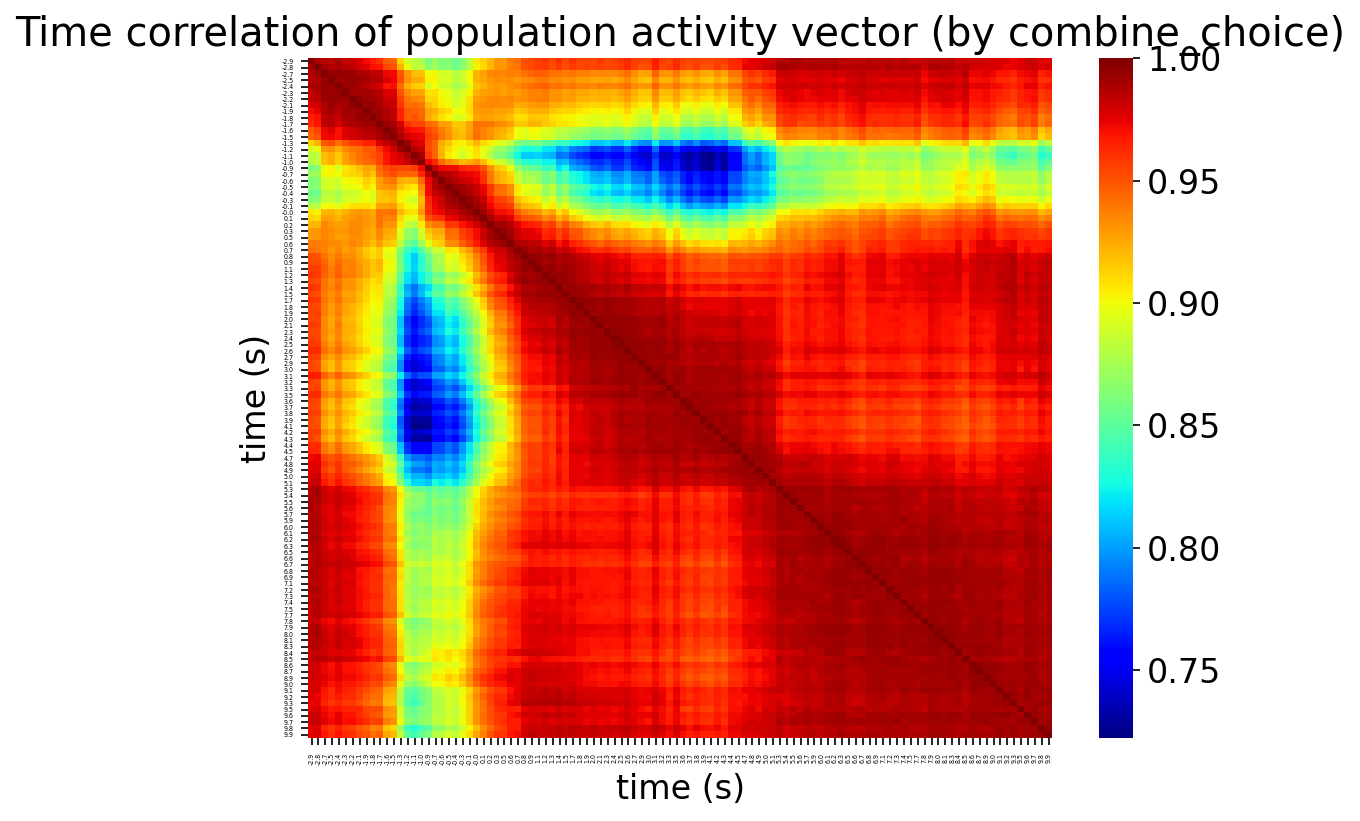

time correlation of population activity vector of contra trials
 corr min: 0.71, max: 1.00
 check negative correlation: False


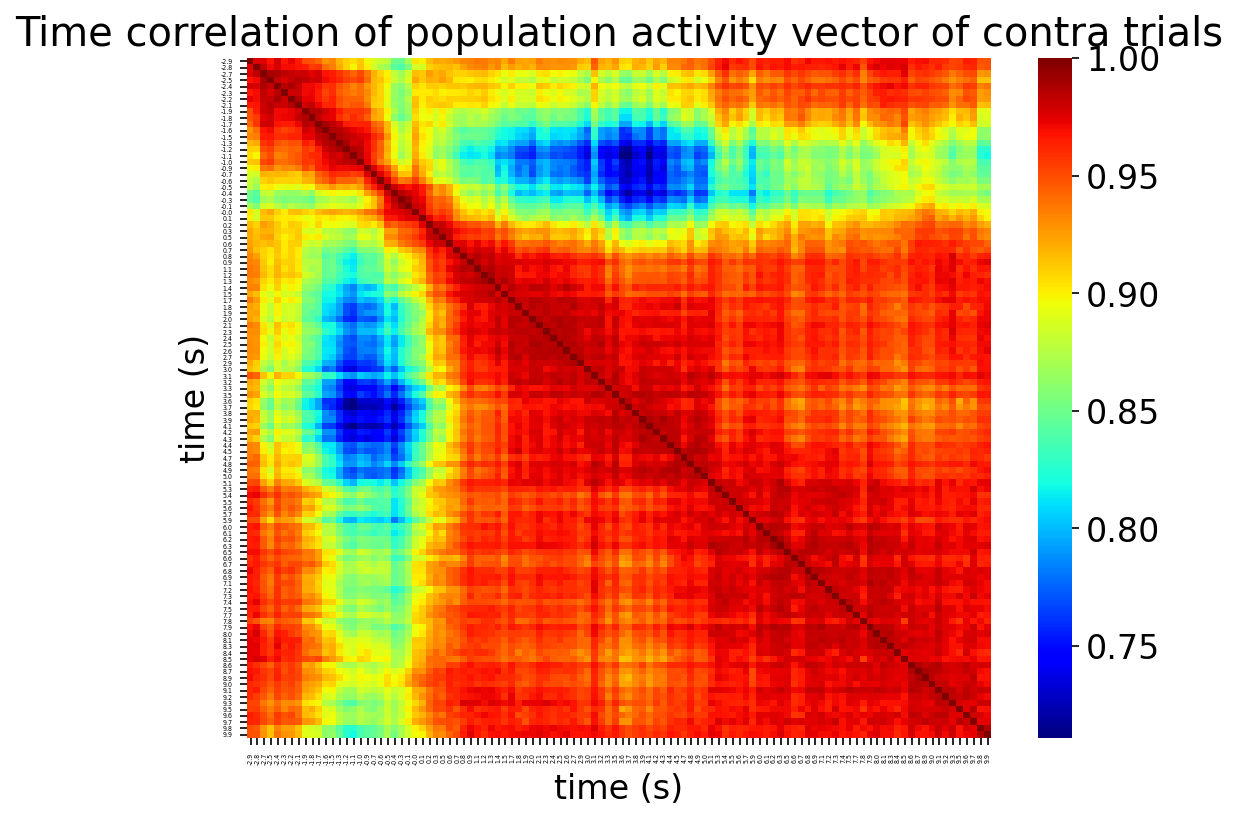

time correlation of population activity vector of ipsi trials
 corr min: 0.66, max: 1.00
 check negative correlation: False


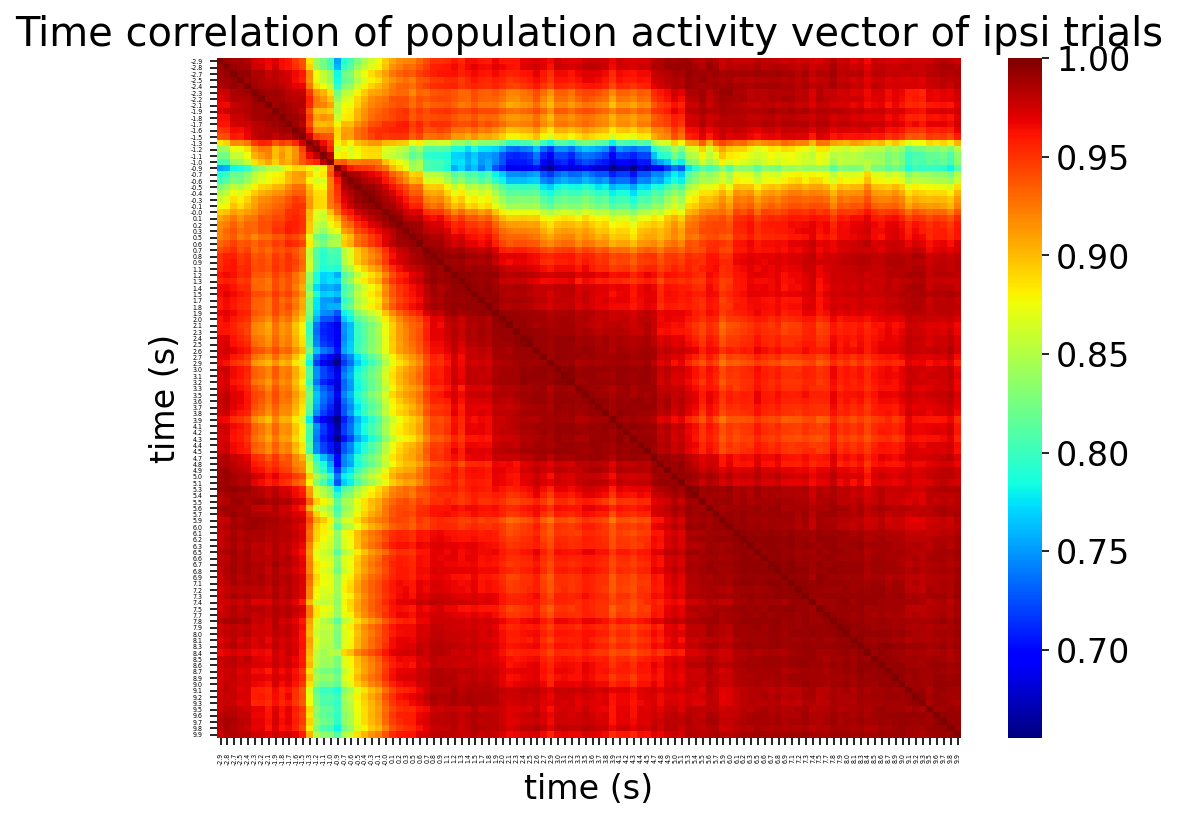

time correlation of population selectivity vector: choice
 corr min: 0.11, max: 1.00
 check negative correlation: False


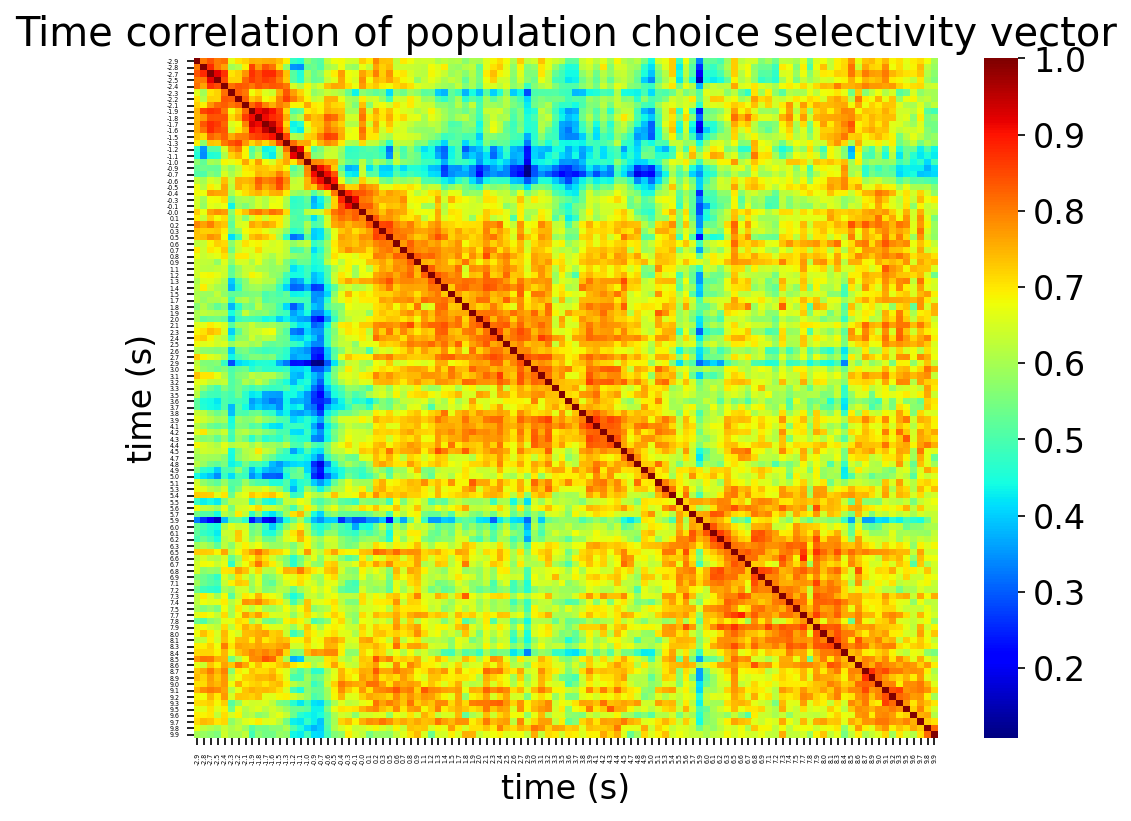

time correlation of population selectivity vector: outcome
 corr min: -0.57, max: 1.00
 check negative correlation: True


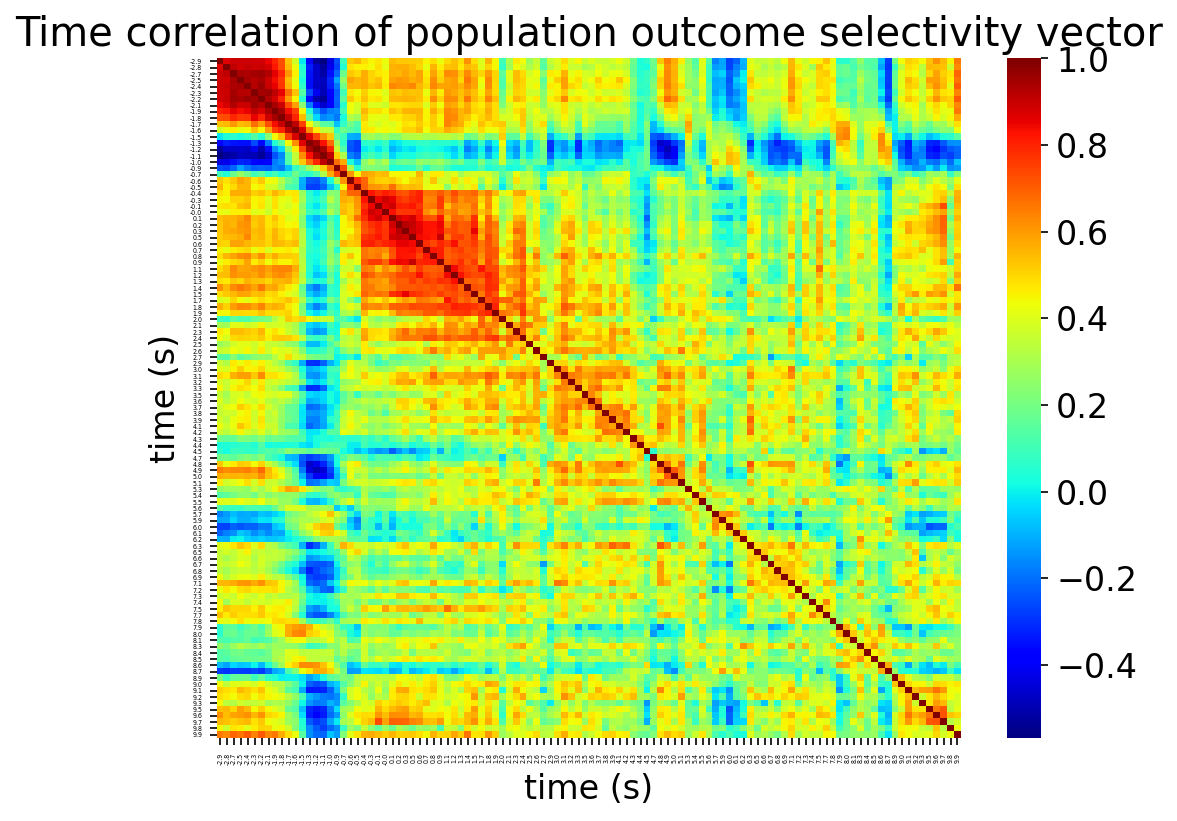

In [45]:
# get population activity vector, trial type specific
pop_act_vec_contra = get_pop_activity_vector_trial_average(pop_psth_contra)
pop_act_vec_ipsi = get_pop_activity_vector_trial_average(pop_psth_ipsi)
pop_act_vec_hit = get_pop_activity_vector_trial_average(pop_psth_hit)
pop_act_vec_miss = get_pop_activity_vector_trial_average(pop_psth_miss)

# get population activity vector, all
pop_act_vec_all = get_pop_activity_vector_trial_average(pop_psth_all)
pop_act_vec_all_combine_choice = get_pop_activity_vector_combine_2_trial_types(pop_act_vec_contra, pop_act_vec_ipsi)
pop_act_vec_all_combine_outcome = get_pop_activity_vector_combine_2_trial_types(pop_act_vec_hit, pop_act_vec_miss)

# get population selectivity vector
pop_sel_vec_choice = get_pop_selectivity_vector(pop_act_vec_contra, pop_act_vec_ipsi)
pop_sel_vec_outcome = get_pop_selectivity_vector(pop_act_vec_hit, pop_act_vec_miss)

# evolution of pop vec
window = 3
print('window for evolution: {}'.format(window))
time_steps = []
for i in range(int(bins.shape[0]/window)):
    time_steps.append(round((bins[window*i] + bins[min(window*(i+1), bins.shape[0]-1)])/2, 1))

## evolution of pop_act_vec
pop_act_vec_all_type_dict = {
    # 'all': pop_act_vec_all,
    'combine_choice': pop_act_vec_all_combine_choice,
    # 'combine_outcome': pop_act_vec_all_combine_outcome
}
for type, pop_act_vec in pop_act_vec_all_type_dict.items():
    print('time correlation of population activity vector: {}'.format(type))
    time_corr_matrix_pop_act_vec = get_vector_evoluation(pop_act_vec, window)
    print(' corr min: {:.2f}, max: {:.2f}'.format(
        np.min(time_corr_matrix_pop_act_vec), np.max(time_corr_matrix_pop_act_vec)))
    print(' check negative correlation: {}'.format(np.min(time_corr_matrix_pop_act_vec)<0))
    plot_pop_vector_time_correlation(time_corr_matrix_pop_act_vec, time_steps, 
        'Time correlation of population activity vector (by {})'.format(type))

## evolution of pop_act_vec by choice
pop_act_vec_choice_dict = {
    'contra': pop_act_vec_contra,
    'ipsi': pop_act_vec_ipsi
}
for type, pop_act_vec_choice in pop_act_vec_choice_dict.items():
    print('time correlation of population activity vector of {} trials'.format(type))
    time_corr_matrix_pop_act_vec_choice = get_vector_evoluation(pop_act_vec_choice, window)
    print(' corr min: {:.2f}, max: {:.2f}'.format(
        np.min(time_corr_matrix_pop_act_vec_choice), np.max(time_corr_matrix_pop_act_vec_choice)))
    print(' check negative correlation: {}'.format(np.min(time_corr_matrix_pop_act_vec_choice)<0))
    plot_pop_vector_time_correlation(time_corr_matrix_pop_act_vec_choice, time_steps, 
        'Time correlation of population activity vector of {} trials'.format(type))

## evolution of pop_sel_vec 
pop_sel_vec_dict = {
    'choice': pop_sel_vec_choice,
    'outcome': pop_sel_vec_outcome
}
for sel_type, pop_sel_vec in pop_sel_vec_dict.items():
    print('time correlation of population selectivity vector: {}'.format(sel_type))
    time_corr_matrix_pop_sel_vec = get_vector_evoluation(pop_sel_vec, window)
    print(' corr min: {:.2f}, max: {:.2f}'.format(
        np.min(time_corr_matrix_pop_sel_vec), np.max(time_corr_matrix_pop_sel_vec)))
    print(' check negative correlation: {}'.format(np.min(time_corr_matrix_pop_sel_vec)<0))
    plot_pop_vector_time_correlation(time_corr_matrix_pop_sel_vec, time_steps, 
        'Time correlation of population {} selectivity vector'.format(sel_type))

In [46]:
def split_index_for_direction_and_projection(num_trial, ratio_direction=0.5):
    '''
    return random half of the indices for direction, the other half for projection
    num_trial: int
    ---
    output: array(num_trial/2), array(num_trial/2)
    '''
    random.seed(SEED)
    ind_direction = np.random.choice(np.arange(num_trial), int(num_trial * ratio_direction), replace=False)
    ind_empty = np.zeros(num_trial, dtype=bool)
    ind_empty[ind_direction] = True
    ind_projection = np.where(~ind_empty)[0]

    return ind_direction, ind_projection


def get_coding_direction_by_window_average(pop_sel_vec, time, time_window):
    '''
    pop_sel_vec: (unit, timebin)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    ---
    output: array(unit)
    '''
    coding_window_index = np.where((time>=time_window[0]) & (time<=time_window[1]))[0]
    print(coding_window_index)
    pop_sel_vec_window_avg = np.average(pop_sel_vec[:, coding_window_index], axis=1)
    print('  check raw coding direction norm: {:.2f}'.format(np.linalg.norm(pop_sel_vec_window_avg)))
    pop_sel_unit_vec = pop_sel_vec_window_avg/ np.linalg.norm(pop_sel_vec_window_avg)
    # print('  check normalized coding direction norm: {}'.format(np.linalg.norm(pop_sel_unit_vec)))
    return pop_sel_unit_vec


def get_go_direction(pop_act_vec, time, time_window):
    '''
    pop_act_vec: (unit, timebin)
    time: (timebin)
    time_window: ()
    ---
    output: (unit)
    '''
    pre_go_window_index = np.where((time>=time_window[0]) & (time<=0.0))[0]  # (t-0.1, t)
    post_go_window_index = np.where((time>=0.0) & (time<=time_window[1]))[0]  # (t, t+0.1)
    print('pre_go window index: {}'.format(pre_go_window_index))
    print('post_go window index: {}'.format(post_go_window_index))
    pop_act_vec_pre_go = np.average(pop_act_vec[:, pre_go_window_index], axis=1)
    pop_act_vec_post_go = np.average(pop_act_vec[:, post_go_window_index], axis=1)
    go_direction = pop_act_vec_post_go - pop_act_vec_pre_go
    print('  check raw go direction norm: {:.2f}'.format(np.linalg.norm(go_direction)))
    go_direction = go_direction/ np.linalg.norm(go_direction)
    # print('  check normalized go direction norm: {:.2f}'.format(np.linalg.norm(go_direction)))
    
    return go_direction


def check_orthgonality(vec1, vec2):
    return np.arccos(np.clip(np.inner(vec1, vec2), -1.0, 1.0)) / 3.14


def gs_orthogonolization(v1, v2):
    '''
    orthogonalize v2 to v1 based on v1
    '''
    proj_on_v1 = np.dot(v2, v1) / np.dot(v1, v1)
    proj_vec = proj_on_v1 * v1
    orthogonalized_v2 = v2 - proj_vec
    
    return orthogonalized_v2 / np.linalg.norm(orthogonalized_v2)


def get_coding_direction_projection(pop_psth, coding_dir):
    '''
    pop_psth: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    ---
    output
    proj_trial_avg: (time_bin)
    proj_trial_sem: ()
    '''
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_dir) # (timebin, trial)
    proj_trial_avg = np.average(proj, axis=1)
    proj_trial_std = np.std(proj, axis=1)
    proj_trial_sem = proj_trial_std / np.sqrt(proj.shape[1])

    return proj_trial_avg, proj_trial_sem
    

def plot_projection_coding_direction(proj_1, proj_1_sem, proj_2, proj_2_sem, bins,
                                     colors, proj_1_source_name, proj_2_source_name, fig_title):
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
    plt.plot(bins, proj_1, color=colors[0], label=proj_1_source_name)
    plt.fill_between(bins, proj_1-proj_1_sem, proj_1+proj_1_sem,
                    alpha=0.5, color=colors[0])
    plt.plot(bins, proj_2, color=colors[1], label=proj_2_source_name)
    plt.fill_between(bins, proj_2-proj_2_sem, proj_2+proj_2_sem,
                     alpha=0.5, color=colors[1])
    plt.axvline(0, color='black', linestyle='dashed')
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    plt.savefig(RESULT_DIRECTORY+fig_title+'.png', dpi=150, facecolor='white', bbox_inches='tight')
    plt.show()


In [47]:
direction_calculation_window_lut = pd.DataFrame(
    np.array([['iti_start', 'choice', 'pre', False, (-2.8, -1.2), 'choice_post_iti_start'],
              ['iti_start', 'outcome', 'pre', False, (-2.5, 0.0), 'outcome_pre_iti_start'],
              ['go_cue', 'choice', 'pre', False, (-0.6, 0.0), 'CD_delay'],
              ['go_cue', 'choice', 'post', False, (0.0, 0.4), 'CD_response'],
              ['go_cue', 'choice', 'post', True, (0.0, 0.4), 'orthogonalized_CD_response'],
              ['go_cue', 'outcome', 'post', False, (1.2, 2), 'outcome_post_go_cue'],
              ['go_cue', 'go', 'across', False, (-0.1, 0.1), 'D_go'],
              ['first_lick_after_go_cue', 'choice', 'pre', False, (-0.6, 0.0), 'CD_delay_lick'],
              ['first_lick_after_go_cue', 'choice', 'post', False, (0.0, 0.4), 'CD_response_lick'],
              ['first_lick_after_go_cue', 'choice', 'post', True, (0.0, 0.4), 'orthogonalized_CD_response_lick'],
              ['first_lick_after_go_cue', 'outcome', 'post', False, (1.2, 2), 'outcome_post_go_cue_lick'],
              ['first_lick_after_go_cue', 'go', 'across', False, (-0.1, 0.1), 'D_go_lick']
            ]),
    columns=['align_type', 'direction_type', 'time_from_align', 'orthogonalized', 'window', 'name']
)
direction_calculation_window_lut

<ipython-input-47-ec2eb10b89c8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([['iti_start', 'choice', 'pre', False, (-2.8, -1.2), 'choice_post_iti_start'],


align_type direction_type time_from_align orthogonalized  \
0                 iti_start         choice             pre          False   
1                 iti_start        outcome             pre          False   
2                    go_cue         choice             pre          False   
3                    go_cue         choice            post          False   
4                    go_cue         choice            post           True   
5                    go_cue        outcome            post          False   
6                    go_cue             go          across          False   
7   first_lick_after_go_cue         choice             pre          False   
8   first_lick_after_go_cue         choice            post          False   
9   first_lick_after_go_cue         choice            post           True   
10  first_lick_after_go_cue        outcome            post          False   
11  first_lick_after_go_cue             go          across          False   

          window                             name  
0   (-2.8, -1.2)            choice_post_iti_start  
1    (-2.5, 0.0)            outcome_pre_iti_start  
2    (-0.6, 0.0)                         CD_delay  
3     (0.0, 0.4)                      CD_response  
4     (0.0, 0.4)       orthogonalized_CD_response  
5       (1.2, 2)              outcome_post_go_cue  
6    (-0.1, 0.1)                             D_go  
7    (-0.6, 0.0)                    CD_delay_lick  
8     (0.0, 0.4)                 CD_response_lick  
9     (0.0, 0.4)  orthogonalized_CD_response_lick  
10      (1.2, 2)         outcome_post_go_cue_lick  
11   (-0.1, 0.1)                        D_go_lick

In [48]:
# calculate coding directions
coding_directions = [] # [direction_type, time_from_align, orthogonalized, coding_direction]

# choice related direction
print('choice direction')
contra_ind_dir, contra_ind_proj = split_index_for_direction_and_projection(pop_psth_contra.shape[2])
print(' contra trials psth shape: {}, selected dir, proj trials: {}, {}'.format(
    pop_psth_contra.shape, contra_ind_dir.shape, contra_ind_proj.shape))
ipsi_ind_dir, ipsi_ind_proj = split_index_for_direction_and_projection(pop_psth_ipsi.shape[2])
print(' ipsi trials psth shape: {}, selected dir, proj trials: {}, {}'.format(
    pop_psth_ipsi.shape, ipsi_ind_dir.shape, ipsi_ind_proj.shape))

pop_act_vec_contra_dir = get_pop_activity_vector_trial_average(pop_psth_contra[:, :, contra_ind_dir])
pop_act_vec_ipsi_dir = get_pop_activity_vector_trial_average(pop_psth_ipsi[:, :, ipsi_ind_dir])
pop_sel_vec_choice = get_pop_selectivity_vector(pop_act_vec_contra_dir, pop_act_vec_ipsi_dir)
direction2calc_list = direction_calculation_window_lut[
                        (direction_calculation_window_lut['align_type'] == align_type) & 
                        (direction_calculation_window_lut['direction_type'] == 'choice') &
                        (direction_calculation_window_lut['orthogonalized'] == False)].values
for direction2calc in direction2calc_list:
    print(' calculate {} {}: {}'.format(direction2calc[2], align_type, direction2calc[-2]))
    coding_directions.append([
        'choice', direction2calc[2], False, 
        get_coding_direction_by_window_average(pop_sel_vec_choice, bins, direction2calc[-2])])


# orthogonalize post_go to pre_go
if align_type in ['go_cue', 'first_lick_after_go_cue']:
    print('orthogonalize CD_response to CD_delay')
    coding_directions.append([
        'choice', 'post', True,
        gs_orthogonolization(coding_directions[0][-1], coding_directions[1][-1])
    ])


# outcome related direction
print('outcome direction')
hit_ind_dir, hit_ind_proj = split_index_for_direction_and_projection(pop_psth_hit.shape[2])
print(' hit trials psth shape: {}, selected dir, proj trials: {}, {}'.format(
    pop_psth_hit.shape, hit_ind_dir.shape, hit_ind_proj.shape))
miss_ind_dir, miss_ind_proj = split_index_for_direction_and_projection(pop_psth_miss.shape[2])
print(' miss trials psth shape: {}, selected dir, proj trials: {}, {}'.format(
    pop_psth_miss.shape, miss_ind_dir.shape, miss_ind_proj.shape))

pop_act_vec_hit_dir = get_pop_activity_vector_trial_average(pop_psth_hit[:, :, hit_ind_dir])
pop_act_vec_miss_dir = get_pop_activity_vector_trial_average(pop_psth_miss[:, :, miss_ind_dir])
pop_sel_vec_outcome = get_pop_selectivity_vector(pop_act_vec_hit_dir, pop_act_vec_miss_dir)
direction2calc_list = direction_calculation_window_lut[(direction_calculation_window_lut['align_type'] == align_type) & 
                                                  (direction_calculation_window_lut['direction_type'] == 'outcome')].values
for direction2calc in direction2calc_list:
    print(' calculate {} {}: {}'.format(direction2calc[2], align_type, direction2calc[-2]))
    coding_directions.append([
        'outcome', direction2calc[2], False,
        get_coding_direction_by_window_average(pop_sel_vec_outcome, bins, direction2calc[-2])])


# go related direction
if align_type in ['go_cue', 'first_lick_after_go_cue']:
    print('go direction')
    pop_act_vec_combine_choice_dir = get_pop_activity_vector_combine_2_trial_types(
                                            pop_act_vec_contra_dir, pop_act_vec_ipsi_dir)
    direction2calc_list = direction_calculation_window_lut[(direction_calculation_window_lut['align_type'] == align_type) & 
                                                    (direction_calculation_window_lut['direction_type'] == 'go')].values
    for direction2calc in direction2calc_list:
        print(' calculate {} {}: {}'.format(direction2calc[2], align_type, direction2calc[-2]))
        coding_directions.append([
            'go', direction2calc[2], False,
            get_go_direction(pop_act_vec_combine_choice_dir, bins, direction2calc[-2])])

choice direction
 contra trials psth shape: (93, 324, 77), selected dir, proj trials: (38,), (39,)
 ipsi trials psth shape: (93, 324, 187), selected dir, proj trials: (93,), (94,)
 calculate pre iti_start: (-2.8, -1.2)
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
  check raw coding direction norm: 25.09
outcome direction
 hit trials psth shape: (93, 324, 129), selected dir, proj trials: (64,), (65,)
 miss trials psth shape: (93, 324, 135), selected dir, proj trials: (67,), (68,)
 calculate pre iti_start: (-2.5, 0.0)
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
  check raw coding direction norm: 21.72


In [49]:
# check orthogonality
direction_angles = []
for i in range(len(coding_directions)):
    for j in range(len(coding_directions)):
        if j < i:
            angle = check_orthgonality(coding_directions[i][-1], coding_directions[j][-1])
            direction_name_1 = direction_calculation_window_lut[
                                    (direction_calculation_window_lut['align_type'] == align_type) & 
                                    (direction_calculation_window_lut['direction_type'] == coding_directions[i][0]) &
                                    (direction_calculation_window_lut['time_from_align'] == coding_directions[i][1]) &
                                    (direction_calculation_window_lut['orthogonalized'] == coding_directions[i][2])].iloc[0]['name']
            direction_name_2 = direction_calculation_window_lut[
                                    (direction_calculation_window_lut['align_type'] == align_type) & 
                                    (direction_calculation_window_lut['direction_type'] == coding_directions[j][0]) &
                                    (direction_calculation_window_lut['time_from_align'] == coding_directions[j][1]) &
                                    (direction_calculation_window_lut['orthogonalized'] == coding_directions[j][2])].iloc[0]['name']
            direction_angles.append([direction_name_1, direction_name_2, round(angle, 2)])
direction_angles = np.array(direction_angles)
df_direction_angles = pd.DataFrame(direction_angles,
                        columns=['direction_1', 'direction_2', 'angle'])
print(df_direction_angles.head())
df_direction_angles.to_csv(RESULT_DIRECTORY+'direction_angles.csv')

             direction_1            direction_2 angle
0  outcome_pre_iti_start  choice_post_iti_start  0.43


In [50]:
projection_normalization_window_lut = pd.DataFrame(
    np.array([['iti_start', 'choice', 'pre', (-2.8, -2.0)],
              ['iti_start', 'outcome', 'pre', (-2.5, 0.0)],
              ['go_cue', 'choice', 'pre', (-0.1, 0.0)],
              ['go_cue', 'choice', 'post', (0.0, 0.4)],
              ['go_cue', 'outcome', 'post', (1.3, 1.8)],
              ['go_cue', 'go', 'across', (-0.1, 0.1)],
              ['first_lick_after_go_cue', 'choice', 'pre', (-0.6, 0.0)],
              ['first_lick_after_go_cue', 'choice', 'post', (0.0, 0.4)],
              ['first_lick_after_go_cue', 'outcome', 'post', (1.2, 2)],
              ['first_lick_after_go_cue', 'go', 'across', (-0.1, 0.1)]
            ]),
    columns=['align_type', 'direction_type', 'time_from_align', 'window']
)
projection_normalization_window_lut

<ipython-input-50-ef9bacc73843>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([['iti_start', 'choice', 'pre', (-2.8, -2.0)],


align_type direction_type time_from_align        window
0                iti_start         choice             pre  (-2.8, -2.0)
1                iti_start        outcome             pre   (-2.5, 0.0)
2                   go_cue         choice             pre   (-0.1, 0.0)
3                   go_cue         choice            post    (0.0, 0.4)
4                   go_cue        outcome            post    (1.3, 1.8)
5                   go_cue             go          across   (-0.1, 0.1)
6  first_lick_after_go_cue         choice             pre   (-0.6, 0.0)
7  first_lick_after_go_cue         choice            post    (0.0, 0.4)
8  first_lick_after_go_cue        outcome            post      (1.2, 2)
9  first_lick_after_go_cue             go          across   (-0.1, 0.1)

In [51]:
def get_baseline_for_projection(pop_psth_baseline, time, time_window):
    '''
    pop_psth_baseline: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    ---
    output
    '''
    baseline_window_index = np.where((time>=time_window[0]) & (time<=time_window[1]))[0]
    pop_psth_baseline = get_pop_activity_vector_trial_average(pop_psth_baseline)
    proj_baseline = np.average(pop_psth_baseline[:, baseline_window_index], axis=1)

    return proj_baseline
    

def get_normalization_factor_for_projection(pop_psth1, pop_psth2, time, time_window):
    '''
    pop_psth1, 2: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    ---
    output
    '''
    pop_psth1_trial_avg = get_pop_activity_vector_trial_average(pop_psth1)
    pop_psth2_trial_avg = get_pop_activity_vector_trial_average(pop_psth2)
    normalization_factor_window_index = np.where((time>=time_window[0]) & (time<=time_window[1]))[0]
    print('normalization time window {}, bins {}'.format(time_window, normalization_factor_window_index))
    normalization_vector = get_pop_selectivity_vector(pop_psth1_trial_avg[:, normalization_factor_window_index], 
                                                      pop_psth2_trial_avg[:, normalization_factor_window_index])
    normalization_vector = np.average(normalization_vector, axis=1)
    print('normalization factor: {}'.format(np.linalg.norm(normalization_vector)))
    return normalization_vector, np.linalg.norm(normalization_vector)


def get_normalized_coding_direction_projection(pop_psth, coding_dir, proj_baseline, proj_normalization_factor): 
    '''
    pop_psth: (unit, timebin, trial)
    coding_dir: (unit)
    pop_psth_baseline: (unit, timebin, trial)
    time: (timebin)
    time_window: tuple (time_start, time_end)
    ---
    output
    proj_trial_avg: (time_bin)
    proj_trial_sem: ()
    '''
    proj_baseline = np.array([[proj_baseline ] *  pop_psth.shape[2]] * pop_psth.shape[1])
    proj_baseline = np.moveaxis(proj_baseline, -1, 0)  # (unit, timebin, trial)
    pop_psth = pop_psth - proj_baseline
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_dir) # (timebin, trial)
    proj = proj / proj_normalization_factor
    proj_trial_avg = np.average(proj, axis=1)
    proj_trial_std = np.std(proj, axis=1)
    proj_trial_sem = proj_trial_std / np.sqrt(proj.shape[1])

    return proj_trial_avg, proj_trial_sem

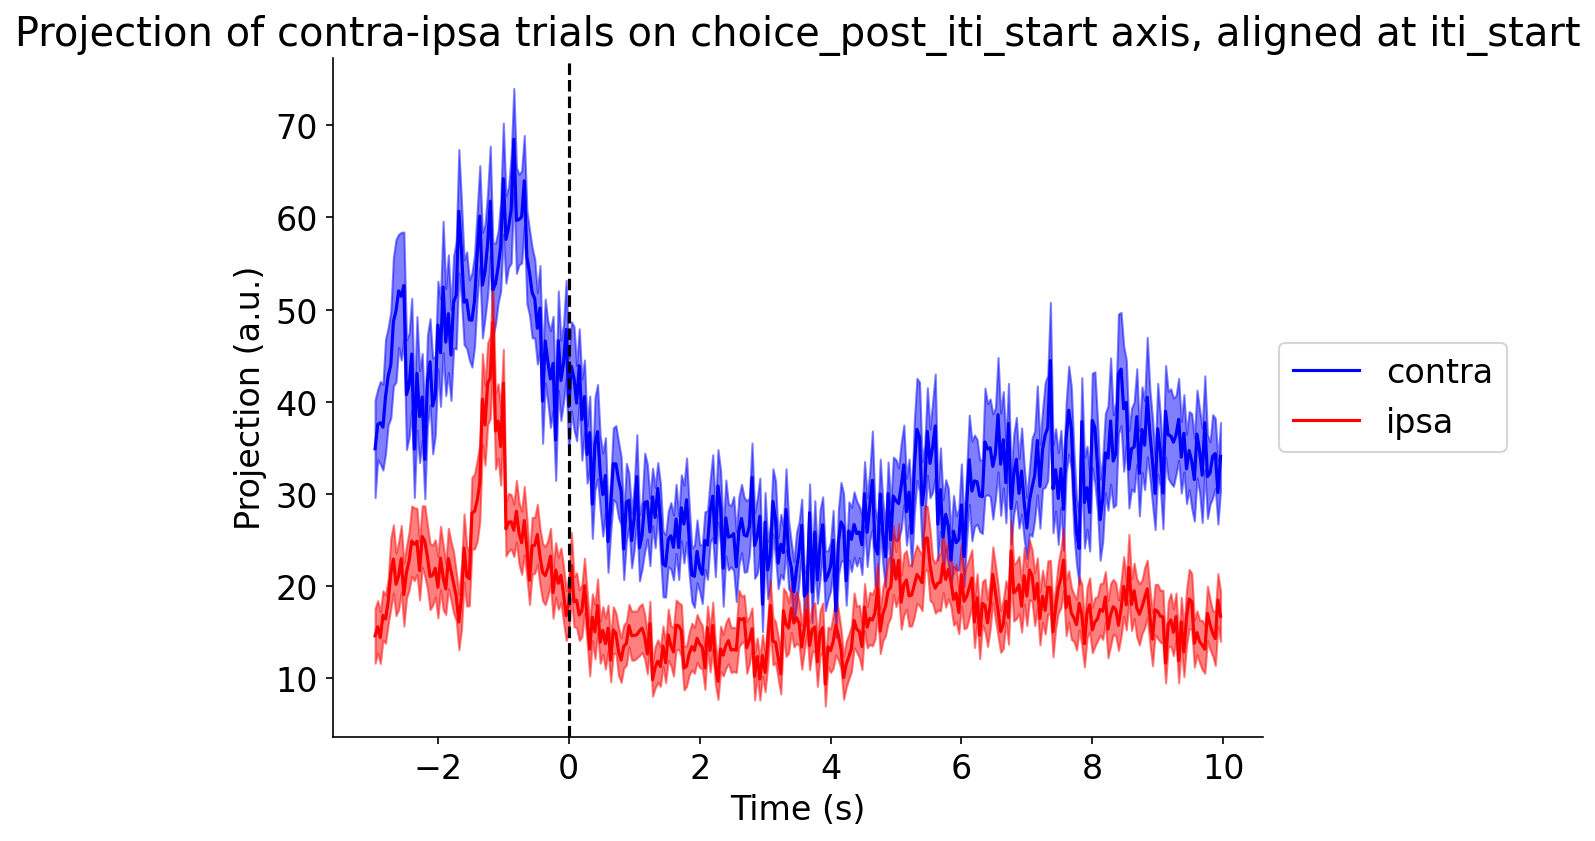

normalization time window (-2.8, -2.0), bins [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
normalization factor: 20.22809601456183
angle between norm_vec and coding direction: 0.0


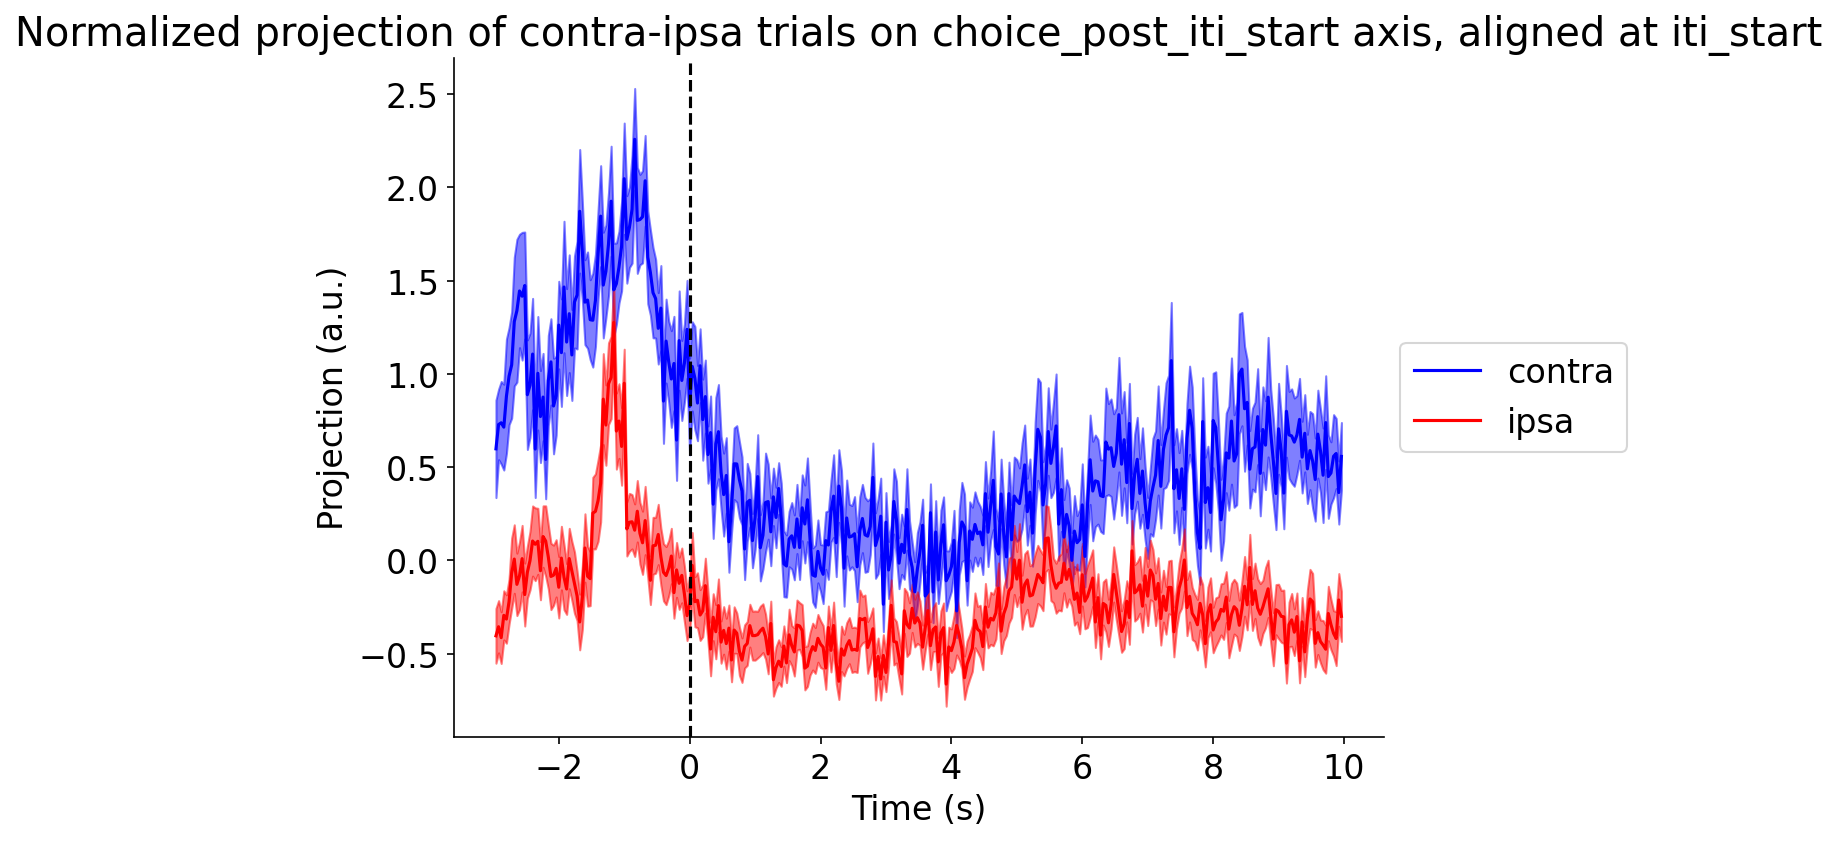

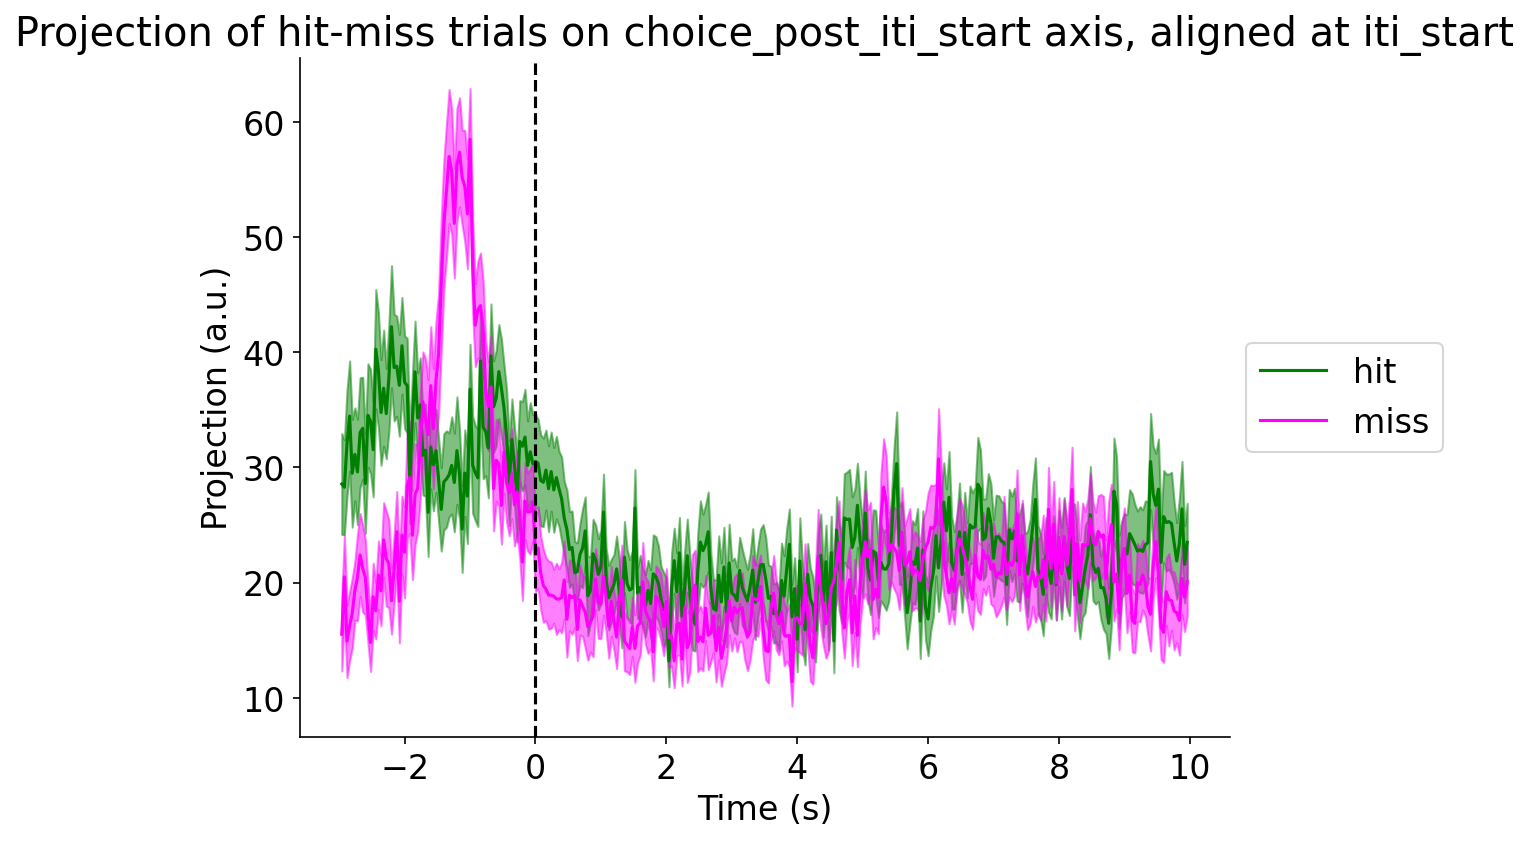

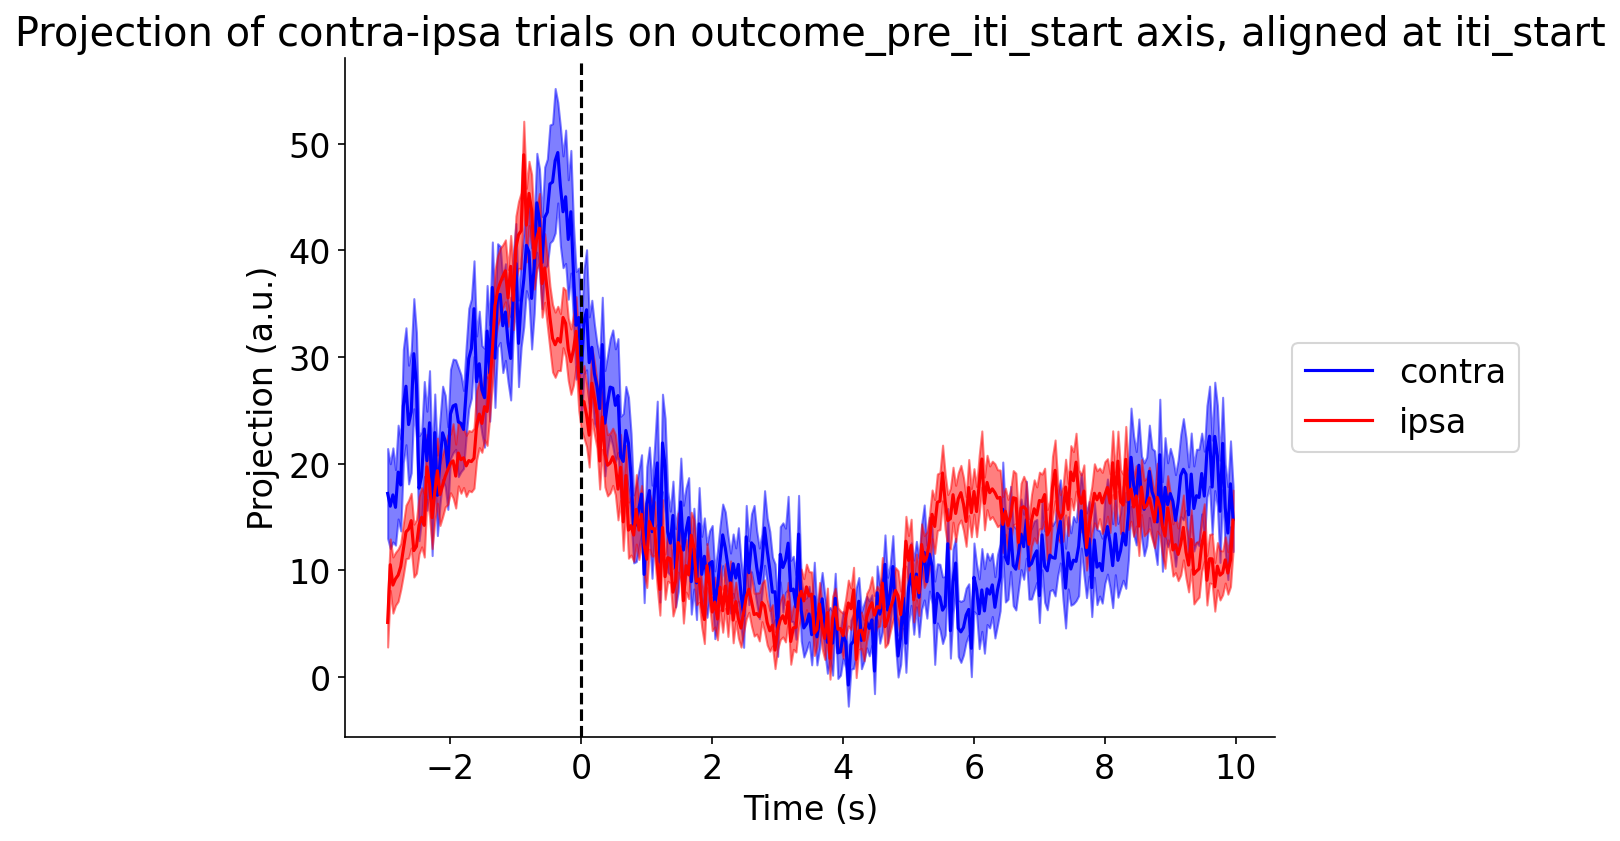

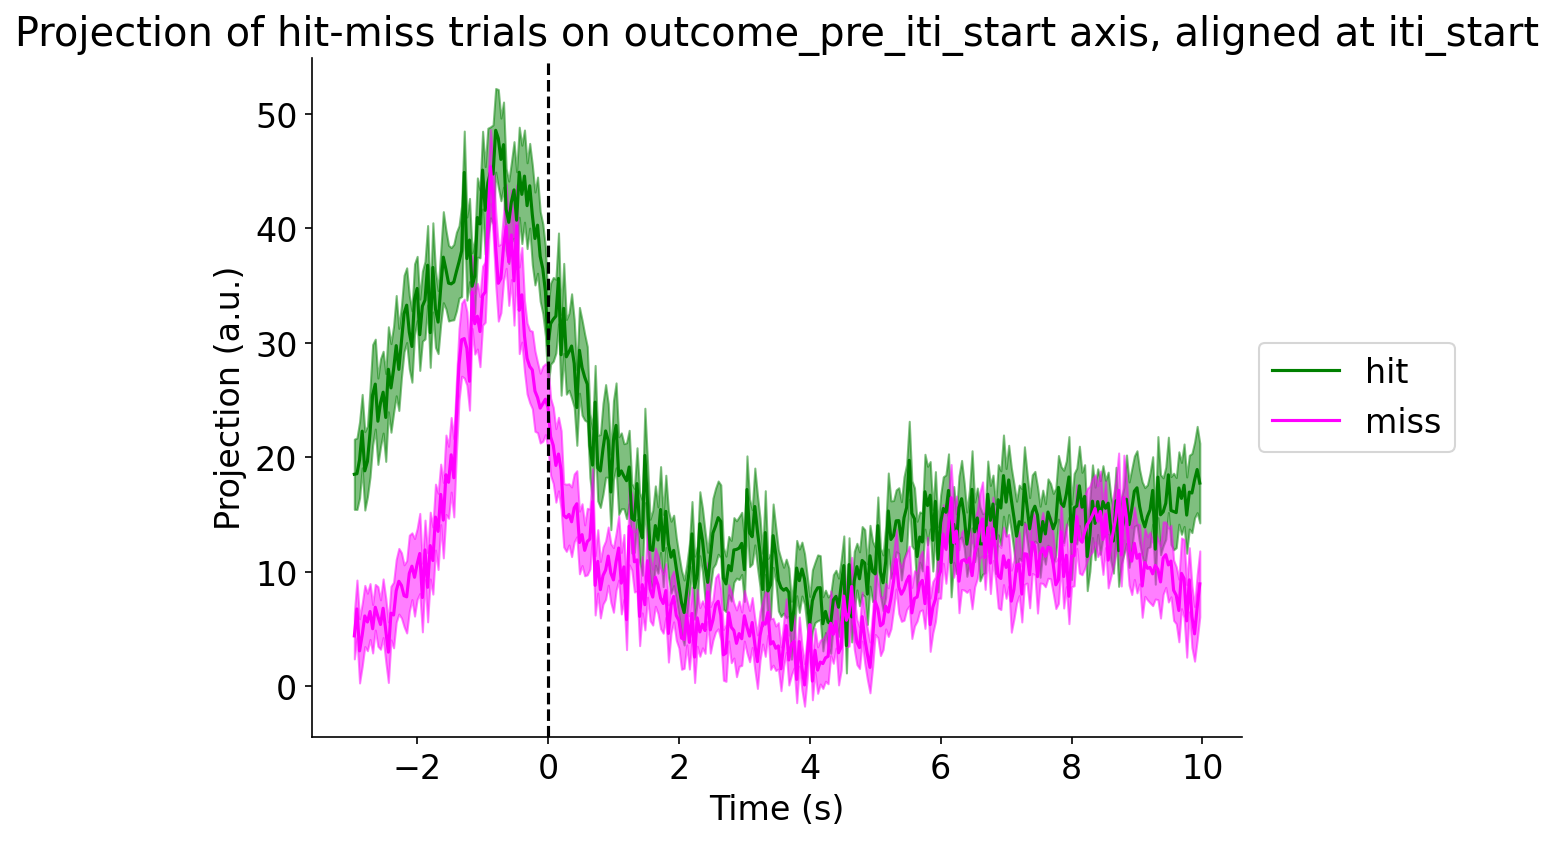

normalization time window (-2.5, 0.0), bins [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
normalization factor: 21.72277595518316
0.0


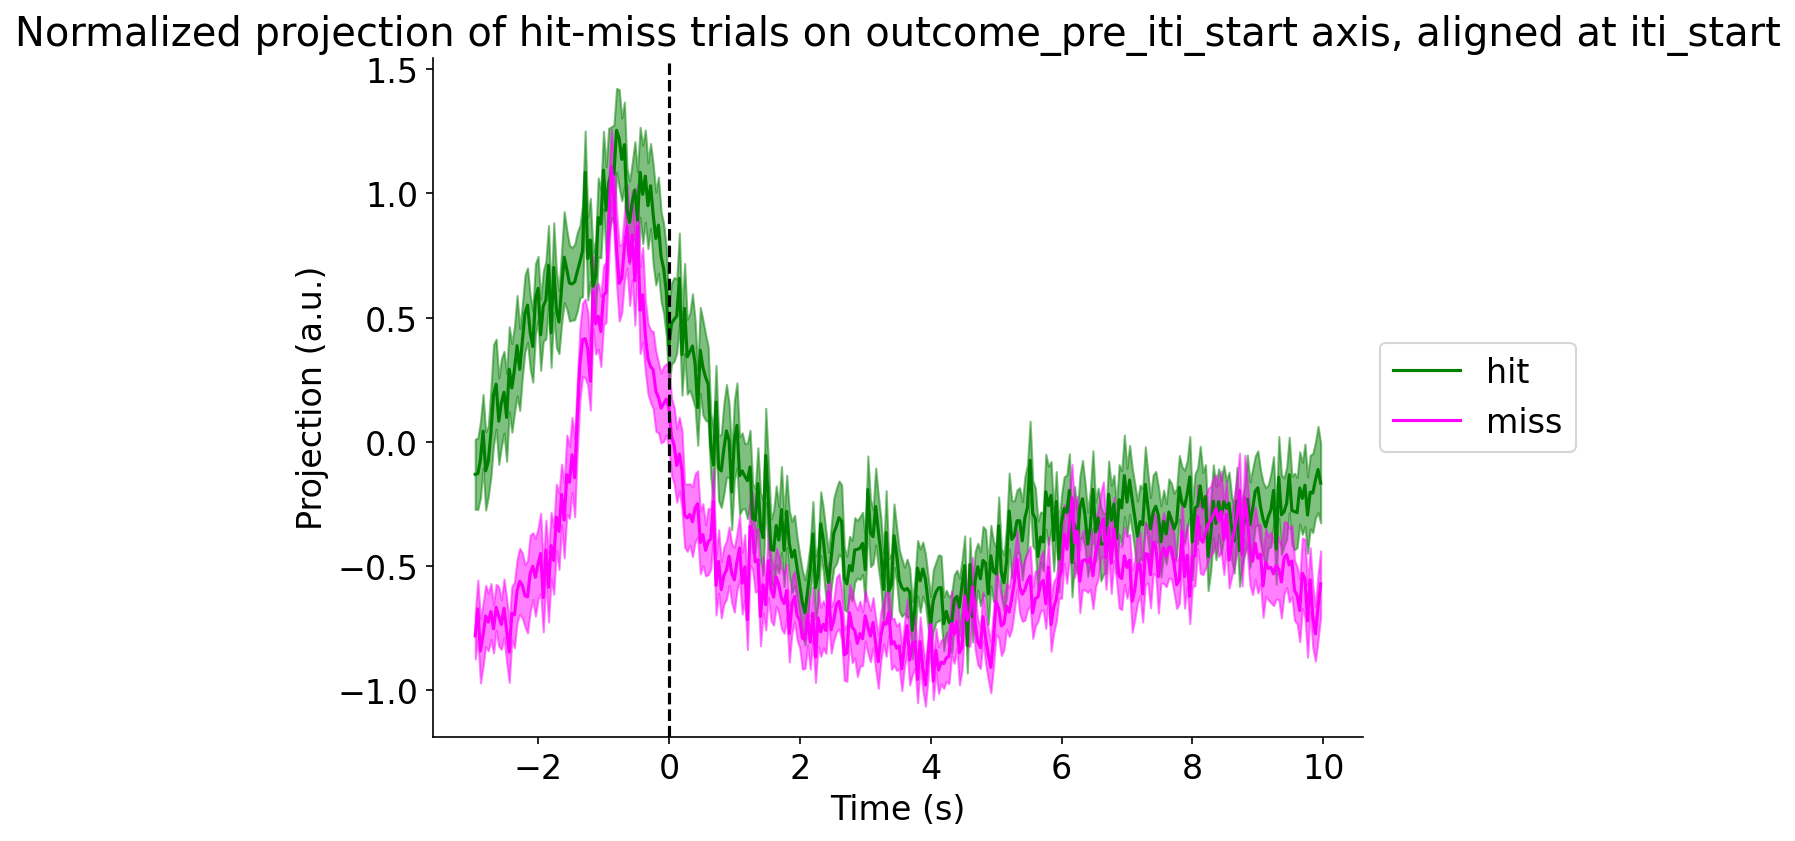

In [52]:
# calculate projections on coding directions
for coding_direction in coding_directions:
    coding_direction_name = direction_calculation_window_lut[
                                (direction_calculation_window_lut['align_type'] == align_type) & 
                                (direction_calculation_window_lut['direction_type'] == coding_direction[0]) &
                                (direction_calculation_window_lut['time_from_align'] == coding_direction[1]) & 
                                (direction_calculation_window_lut['orthogonalized'] == coding_direction[2])].iloc[0]['name']
    
    # contra/ ipsi projections
    contra_proj_coding_dir, contra_proj_coding_dir_sem = get_coding_direction_projection(
        pop_psth_contra[:, :, contra_ind_proj], coding_direction[-1])
    ipsi_proj_coding_dir, ipsi_proj_coding_dir_sem = get_coding_direction_projection(
        pop_psth_ipsi[: ,:, ipsi_ind_proj], coding_direction[-1])
    colors = ('b', 'r')
    proj_1_source_name, proj_2_source_name = 'contra', 'ipsa'
    title = 'Projection of {}-{} trials on {} axis, aligned at {}'.format(
        proj_1_source_name, proj_2_source_name, coding_direction_name, align_type)
    plot_projection_coding_direction(contra_proj_coding_dir, contra_proj_coding_dir_sem, 
                                ipsi_proj_coding_dir, ipsi_proj_coding_dir_sem, 
                                bins, colors, proj_1_source_name, proj_2_source_name, title)
    # normalization
    if coding_direction[0] == 'choice':  
        proj_normalization_window = projection_normalization_window_lut[
                                    (projection_normalization_window_lut['align_type'] == align_type) & 
                                    (projection_normalization_window_lut['direction_type'] == coding_direction[0]) &
                                    (projection_normalization_window_lut['time_from_align'] == coding_direction[1])].iloc[0]['window']
        proj_baseline = get_baseline_for_projection(pop_psth_ipsi[: ,:, ipsi_ind_dir], 
                                                    bins, proj_normalization_window)
        norm_vec, proj_normalization_factor = get_normalization_factor_for_projection(
                                        pop_psth_contra[:, :, contra_ind_dir],
                                        pop_psth_ipsi[: ,:, ipsi_ind_dir], 
                                        bins, proj_normalization_window)
        print('angle between norm_vec and coding direction: {}'.format(check_orthgonality(norm_vec, coding_direction[-1])))
        normalized_contra_proj_coding_dir, normalized_contra_proj_coding_dir_sem = get_normalized_coding_direction_projection(
            pop_psth_contra[:, :, contra_ind_proj], coding_direction[-1], 
            proj_baseline, proj_normalization_factor)
        normalized_ipsi_proj_coding_dir, normalized_ipsi_proj_coding_dir_sem = get_normalized_coding_direction_projection(
            pop_psth_ipsi[:, :, ipsi_ind_proj], coding_direction[-1], 
            proj_baseline, proj_normalization_factor)
        colors = ('b', 'r')
        proj_1_source_name, proj_2_source_name = 'contra', 'ipsa'
        title = 'Normalized projection of {}-{} trials on {} axis, aligned at {}'.format(
            proj_1_source_name, proj_2_source_name, coding_direction_name, align_type)
        plot_projection_coding_direction(
            normalized_contra_proj_coding_dir, normalized_contra_proj_coding_dir_sem, 
            normalized_ipsi_proj_coding_dir, normalized_ipsi_proj_coding_dir_sem, 
            bins, colors, proj_1_source_name, proj_2_source_name, title)

    # hit/miss projections
    hit_proj_coding_dir, hit_proj_coding_dir_sem = get_coding_direction_projection(
        pop_psth_hit[:, :, hit_ind_proj], coding_direction[-1])
    miss_proj_coding_dir, miss_proj_coding_dir_sem = get_coding_direction_projection(
        pop_psth_miss[: ,:, miss_ind_proj], coding_direction[-1])
    colors = ('green', 'magenta')
    proj_1_source_name, proj_2_source_name = 'hit', 'miss'
    title = 'Projection of {}-{} trials on {} axis, aligned at {}'.format(
        proj_1_source_name, proj_2_source_name, coding_direction_name, align_type)
    plot_projection_coding_direction(hit_proj_coding_dir, hit_proj_coding_dir_sem, 
                                miss_proj_coding_dir, miss_proj_coding_dir_sem, 
                                bins, colors, proj_1_source_name, proj_2_source_name, title)
    
    # normalization
    if coding_direction[0] == 'outcome':  
        proj_normalization_window = projection_normalization_window_lut[
                                    (projection_normalization_window_lut['align_type'] == align_type) & 
                                    (projection_normalization_window_lut['direction_type'] == coding_direction[0]) &
                                    (projection_normalization_window_lut['time_from_align'] == coding_direction[1])].iloc[0]['window']
        proj_baseline = get_baseline_for_projection(pop_psth_miss[: ,:, miss_ind_dir], 
                                                    bins, proj_normalization_window)
        norm_vec, proj_normalization_factor = get_normalization_factor_for_projection(
                                        pop_psth_hit[:, :, hit_ind_dir],
                                        pop_psth_miss[: ,:, miss_ind_dir], 
                                        bins, proj_normalization_window)
        print(check_orthgonality(norm_vec, coding_direction[-1]))
        normalized_hit_proj_coding_dir, normalized_hit_proj_coding_dir_sem = get_normalized_coding_direction_projection(
            pop_psth_hit[:, :, hit_ind_proj], coding_direction[-1], 
            proj_baseline, proj_normalization_factor)
        normalized_miss_proj_coding_dir, normalized_miss_proj_coding_dir_sem = get_normalized_coding_direction_projection(
            pop_psth_miss[:, :, miss_ind_proj], coding_direction[-1], 
            proj_baseline, proj_normalization_factor)
        colors = ('green', 'magenta')
        proj_1_source_name, proj_2_source_name = 'hit', 'miss'
        title = 'Normalized projection of {}-{} trials on {} axis, aligned at {}'.format(
            proj_1_source_name, proj_2_source_name, coding_direction_name, align_type)
        plot_projection_coding_direction(
            normalized_hit_proj_coding_dir, normalized_hit_proj_coding_dir_sem, 
            normalized_miss_proj_coding_dir, normalized_miss_proj_coding_dir_sem, 
            bins, colors, proj_1_source_name, proj_2_source_name, title)

## dsPCA

In [40]:
# fetch independent variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable
                    & keys2trials_all
                    & {'model_id': 10})

# fetch independent variables?
df = util._get_unit_independent_variable(keys2units[0], model_id=10)
df

trial  subject_id  session  model_id left_ right_ contra_  ipsi_  \
0        1      473361       50        10  left  right    left  right   
1        2      473361       50        10  left  right    left  right   
2        3      473361       50        10  left  right    left  right   
3        4      473361       50        10  left  right    left  right   
4        6      473361       50        10  left  right    left  right   
..     ...         ...      ...       ...   ...    ...     ...    ...   
267    382      473361       50        10  left  right    left  right   
268    383      473361       50        10  left  right    left  right   
269    384      473361       50        10  left  right    left  right   
270    385      473361       50        10  left  right    left  right   
271    386      473361       50        10  left  right    left  right   

     left_action_value  right_action_value  ...  ipsi_choice_kernel  \
0             0.480016            0.000000  ...                 NaN   
1             0.729617            0.000000  ...                 NaN   
2             0.859405            0.000000  ...                 NaN   
3             0.446877            0.000000  ...                 NaN   
4             0.712385            0.000000  ...                 NaN   
..                 ...                 ...  ...                 ...   
267           0.001339            0.739947  ...                 NaN   
268           0.000696            0.864777  ...                 NaN   
269           0.000362            0.449670  ...                 NaN   
270           0.000188            0.233821  ...                 NaN   
271           0.000098            0.121583  ...                 NaN   

     relative_action_value_lr  relative_action_value_ic  total_action_value  \
0                   -0.480016                  0.480016            0.480016   
1                   -0.729617                  0.729617            0.729617   
2                   -0.859405                  0.859405            0.859405   
3                   -0.446877                  0.446877            0.446877   
4                   -0.712385                  0.712385            0.712385   
..                        ...                       ...                 ...   
267                  0.738609                 -0.738609            0.741286   
268                  0.864081                 -0.864081            0.865473   
269                  0.449308                 -0.449308            0.450032   
270                  0.233633                 -0.233633            0.234009   
271                  0.121485                 -0.121485            0.121681   

     choice  choice_lr  choice_ic  outcome  reward       rpe  
0      left          0          1      hit       1       1.0  
1      left          0          1      hit       1  0.519984  
2      left          0          1      hit       1  0.270383  
3      left          0          1     miss       0 -0.859405  
4      left          0          1      hit       1  0.553123  
..      ...        ...        ...      ...     ...       ...  
267   right          1          0      hit       1  0.500117  
268   right          1          0      hit       1  0.260053  
269    left          0          1     miss       0 -0.000696  
270    left          0          1     miss       0 -0.000362  
271    left          0          1     miss       0 -0.000188  

[272 rows x 29 columns]

In [1]:
import pandas as pd
from dspca.dspca import dsPCA
import matplotlib.colors as colors


df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left'].sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right'].sort_values(by=['trial'])


# generate targets matrix for dsPCA
# delta_Q
delta_Q = df_Q_left['action_value'].values - df_Q_right['action_value'].values
print('delta_Q: {}'.format(delta_Q.shape))

# sigma_Q
sigma_Q = df_Q_left['action_value'].values + df_Q_right['action_value'].values
print('sigma_Q: {}'.format(sigma_Q.shape))

# choice_Q
trials_all.fetch('water_port').shape
left_trial_ind = np.where(trials_all.fetch('water_port')=='left')
right_trial_ind = np.where(trials_all.fetch('water_port')=='right')

left_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
left_trial_indicator[left_trial_ind] = 1
right_trial_indicator = np.zeros_like(trials_all.fetch('water_port'))
right_trial_indicator[right_trial_ind] = 1

left_choice_Q = df_Q_left['action_value'].values * left_trial_indicator
right_choice_Q = df_Q_right['action_value'].values * right_trial_indicator
choice_Q = left_choice_Q + right_choice_Q
print('choice_Q: {}'.format(choice_Q.shape))

NameError: name 'q_latent_variable' is not defined

In [42]:
# prepare data matrix for dsPCA
# data ([# of observations] X [# of dimensions to be reduced]) 
# targets ([# of observations] X [# of targets])

# for isi: take only time < 2.5s
time_limit = 2.5
data = pop_psth_all[:, :, np.where(bins < time_limit)[0]]
data = np.average(data, axis=2).transpose()
print('input data shape: {}'.format(data.shape))

targets_list = [delta_Q, sigma_Q, choice_Q]
targets = np.vstack(targets_list).transpose()
print('input targets shape: {}'.format(targets.shape))

# dsPCA
[projection_target_subspace, projection_targetfree_subspace, ax_targets, ax_targetfree, 
 target_subspace_signal, targetfree_subspace_signal, target_subspace_var, targetfree_subspace_var,
 total_var, dot_target_ax] = dsPCA(data=data, targets=targets)

print('target_subspace_var: {}'.format(target_subspace_var))
print('targetfree_subspace_var: {}'.format(targetfree_subspace_var[:10]))
print('projection_target_subspace: {}'.format(projection_target_subspace.shape))
print('projection_targetfree_subspace: {}'.format(projection_targetfree_subspace.shape))
print('ax_targets: {}'.format(ax_targets.shape))
print('ax_targetfree: {}'.format(ax_targetfree.shape))
print('check axis norm: {}'.format(np.linalg.norm(ax_targets[:, 0])))

input data shape: (264, 97)
input targets shape: (264, 3)
target_subspace_var: [274.51161982 404.36032635 353.81595241]
targetfree_subspace_var: [393.71556345 167.95955495  79.46770291  70.03746034  64.28337135
  52.78701925  46.9805044   35.6908944   33.74603603  32.03580234]
projection_target_subspace: (264, 3)
projection_targetfree_subspace: (264, 94)
ax_targets: (97, 3)
ax_targetfree: (97, 94)
check axis norm: 0.9999999999999998


In [43]:
# correlation between axis
targets_name = ['delta_Q', 'sigma_Q', 'choice_Q']
for i in range(3):
    for j in range(3):
        if i < j:
            print('correlation between {} and {} axes: {}'.format(
                targets_name[i], targets_name[j],
                np.inner(ax_targets[:, i], ax_targets[:, j])))

for i in range(3):
    for j in range(3):
        print('correlation between {} and target_free {} axes: {}'.format(
                targets_name[i], j,
                np.inner(ax_targets[:, i], ax_targetfree[:, j])))

correlation between delta_Q and sigma_Q axes: -0.28626483765672384
correlation between delta_Q and choice_Q axes: 0.35435109634084444
correlation between sigma_Q and choice_Q axes: -0.9368082432220486
correlation between delta_Q and target_free 0 axes: 4.132165529885379e-17
correlation between delta_Q and target_free 1 axes: -5.289551349013655e-17
correlation between delta_Q and target_free 2 axes: 6.489797035272998e-17
correlation between sigma_Q and target_free 0 axes: -1.3823577699190182e-16
correlation between sigma_Q and target_free 1 axes: 1.000989655747242e-16
correlation between sigma_Q and target_free 2 axes: 1.3032448926454665e-17
correlation between choice_Q and target_free 0 axes: 1.3370923292177483e-16
correlation between choice_Q and target_free 1 axes: -9.725293487194975e-17
correlation between choice_Q and target_free 2 axes: -4.791834789207028e-17


In [44]:
def get_dspca_axis_projection(pop_psth, coding_axis):
    proj = np.inner(np.moveaxis(pop_psth, 0, -1), coding_axis)
    proj_avg = np.average(proj, axis=0)
    proj_std = np.std(proj, axis=0)
    proj_sem = proj_std / np.sqrt(proj.shape[0])

    return proj_avg, proj_sem


def get_psth_by_target_5_division(target_value_arr):
    # get 5 division of psth

    target_hist = plt.hist(target_value_arr, bins=5, cumulative=True)
    sorted_ind_by_target = np.argsort(target_value_arr)
    print(sorted_ind_by_target.shape)

    pop_psth_target_5_div = []
    for i in range(target_hist[0].shape[0]):
        if i == 0:
            print(0, int(target_hist[0][i]))
            pop_psth_target_5_div.append(pop_psth_all[:, sorted_ind_by_target[:int(target_hist[0][i])], :])
        else:
            print(int(target_hist[0][i-1]), int(target_hist[0][i]))
            pop_psth_target_5_div.append(pop_psth_all[:, sorted_ind_by_target[int(target_hist[0][i-1]):int(target_hist[0][i])], :])

    print(pop_psth_target_5_div[0].shape)

    return target_hist, pop_psth_target_5_div


def plot_proj_on_axis_by_target_5_division(pop_psth_target_5_div, ax_targets, target_hist, target='delta_Q', axis='delta_Q'):
    
    axis_table = {'delta_Q': 0, 'sigma_Q': 1, 'choice_Q': 2}
    fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
    for i, c in zip(range(5), colors.TABLEAU_COLORS):
        proj_avg, proj_sem = get_dspca_axis_projection(pop_psth_target_5_div[i], ax_targets[:, axis_table[axis]])
        plt.plot(bins, proj_avg, c=c, label='{} ({:.2f}, {:.2f}): n={}'.format(target, target_hist[1][i], target_hist[1][i+1], 
                                                                               int(target_hist[0][i] - target_hist[0][i-1] if i > 0 else target_hist[0][i])))
        plt.fill_between(bins, proj_avg-proj_sem, proj_avg+proj_sem,
                        alpha=0.5, color=c)
    plt.title('Projection of population psth onto {} axis, grouped by {}'.format(axis, target))
    plt.xlabel('Time (s)')
    plt.ylabel('Projection (a.u.)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    plt.show()


(264,)
0 26
26 71
71 140
140 205
205 264
(97, 26, 324)


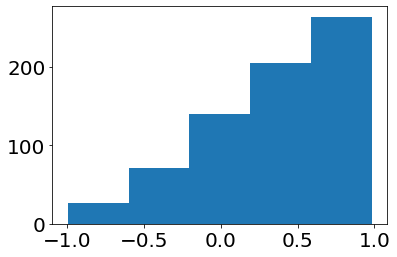

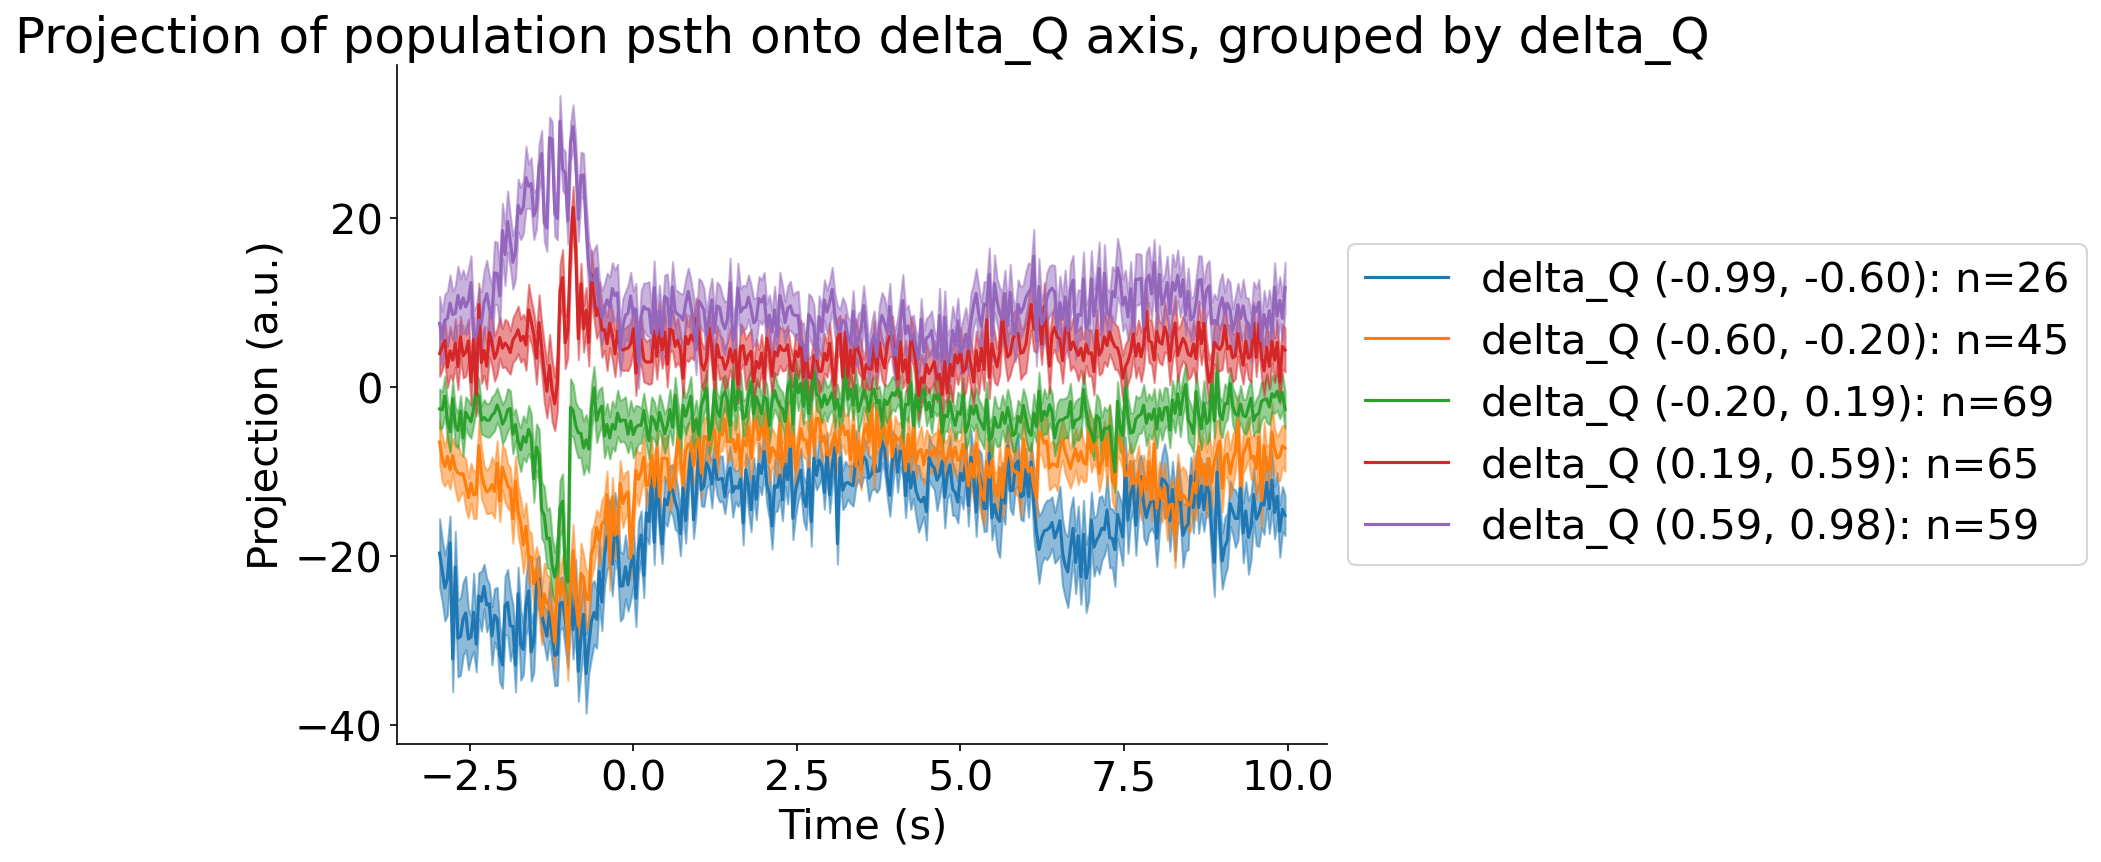

(264,)
0 57
57 108
108 164
164 217
217 264
(97, 57, 324)


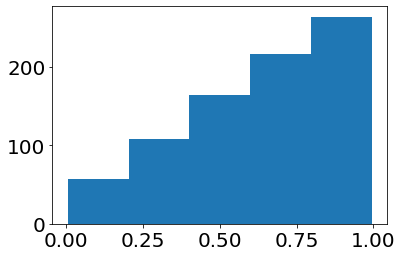

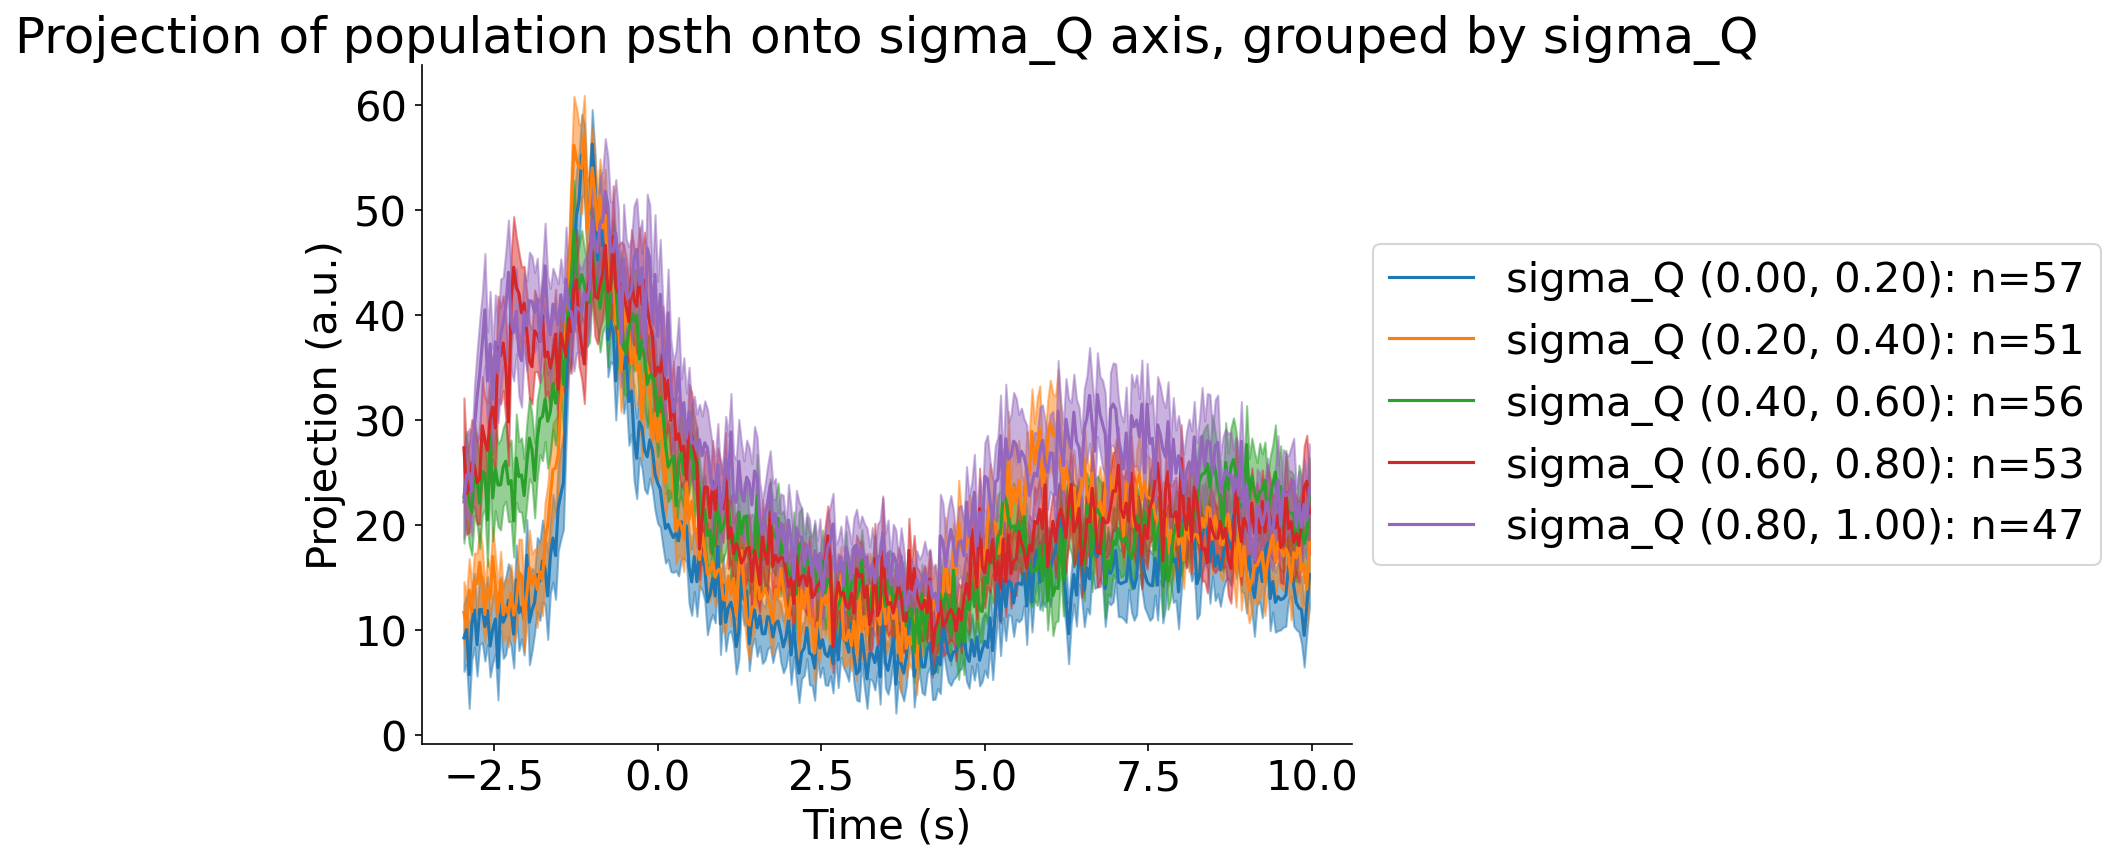

(264,)
0 68
68 114
114 177
177 226
226 264
(97, 68, 324)


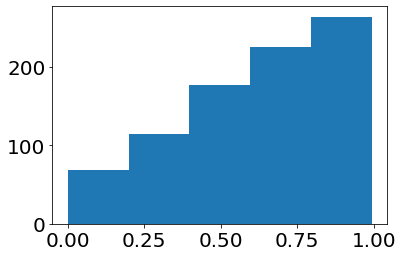

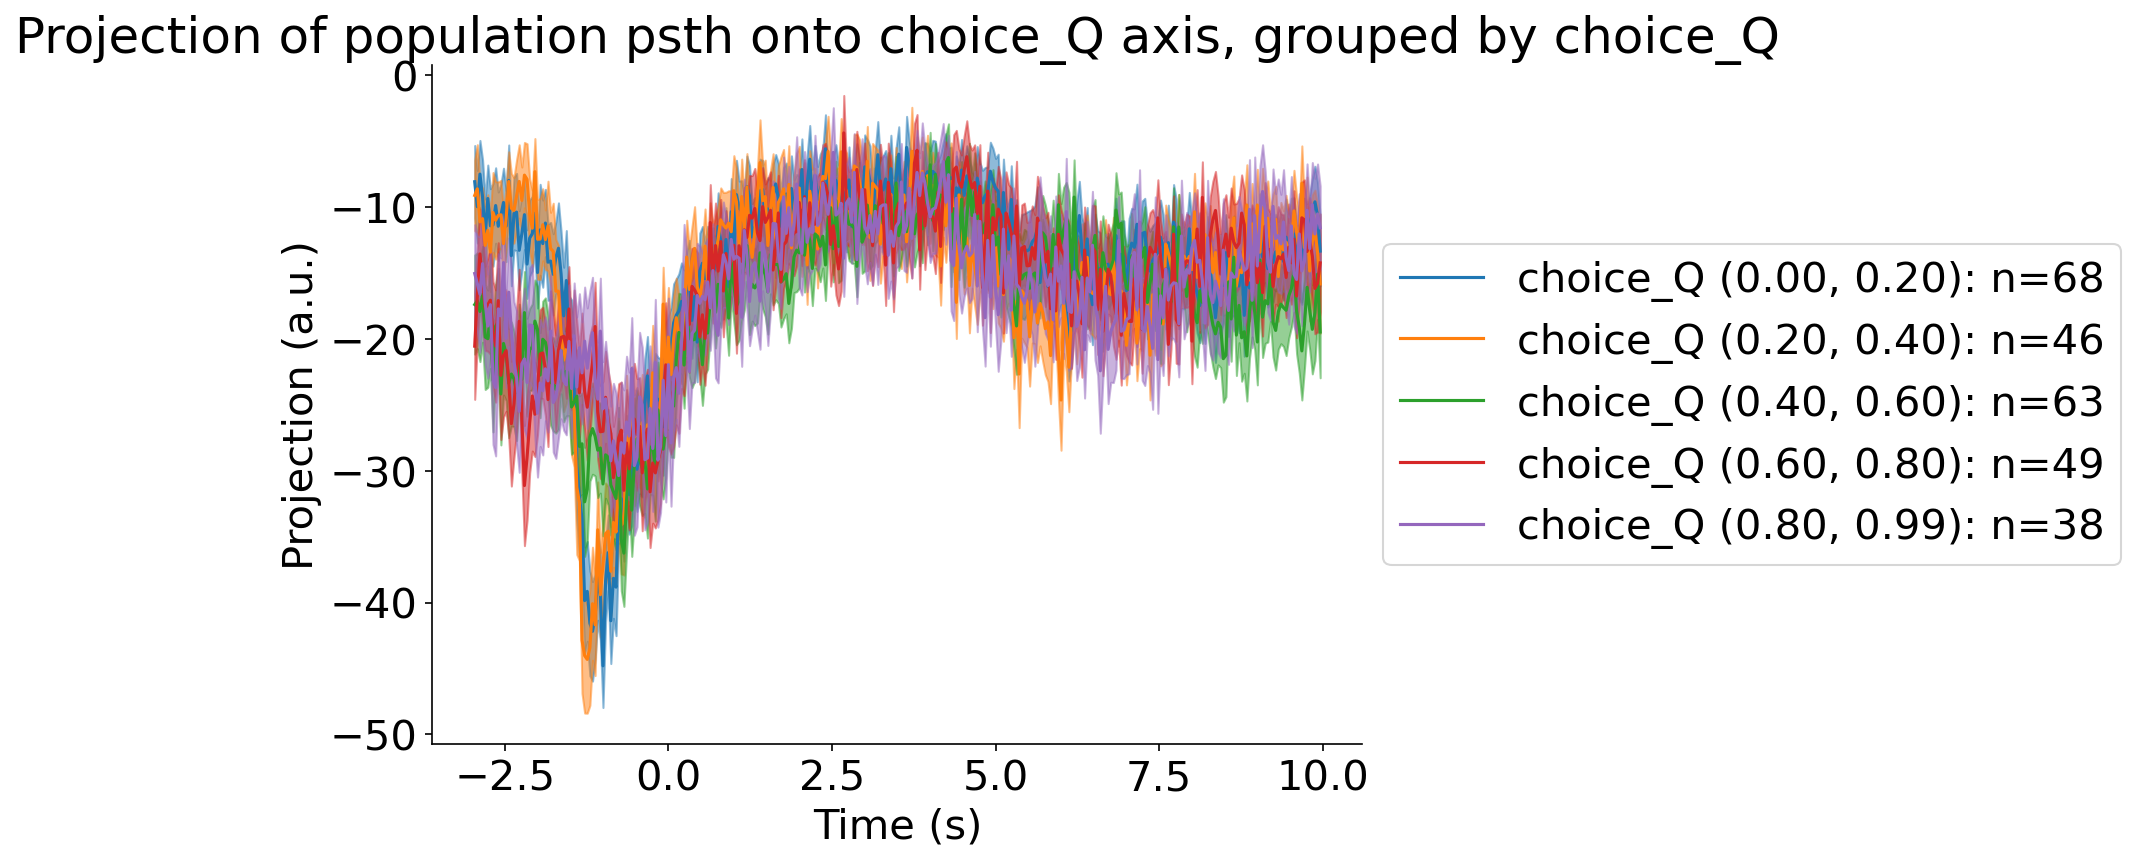

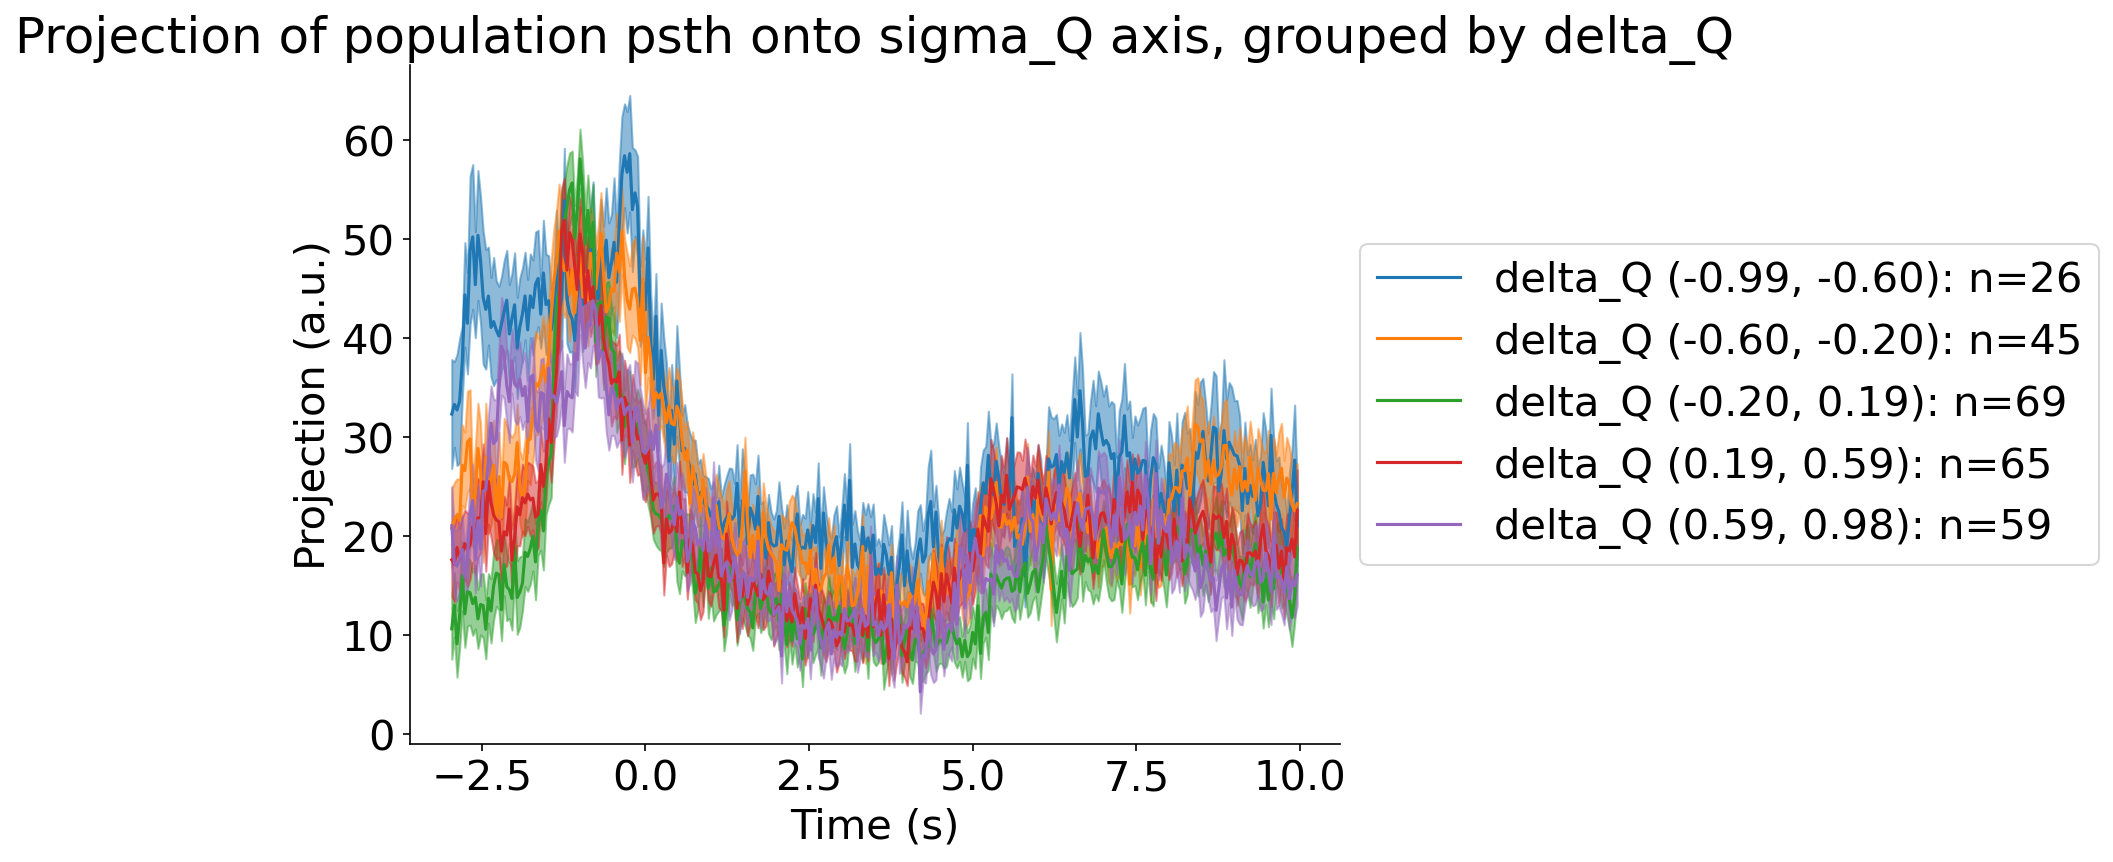

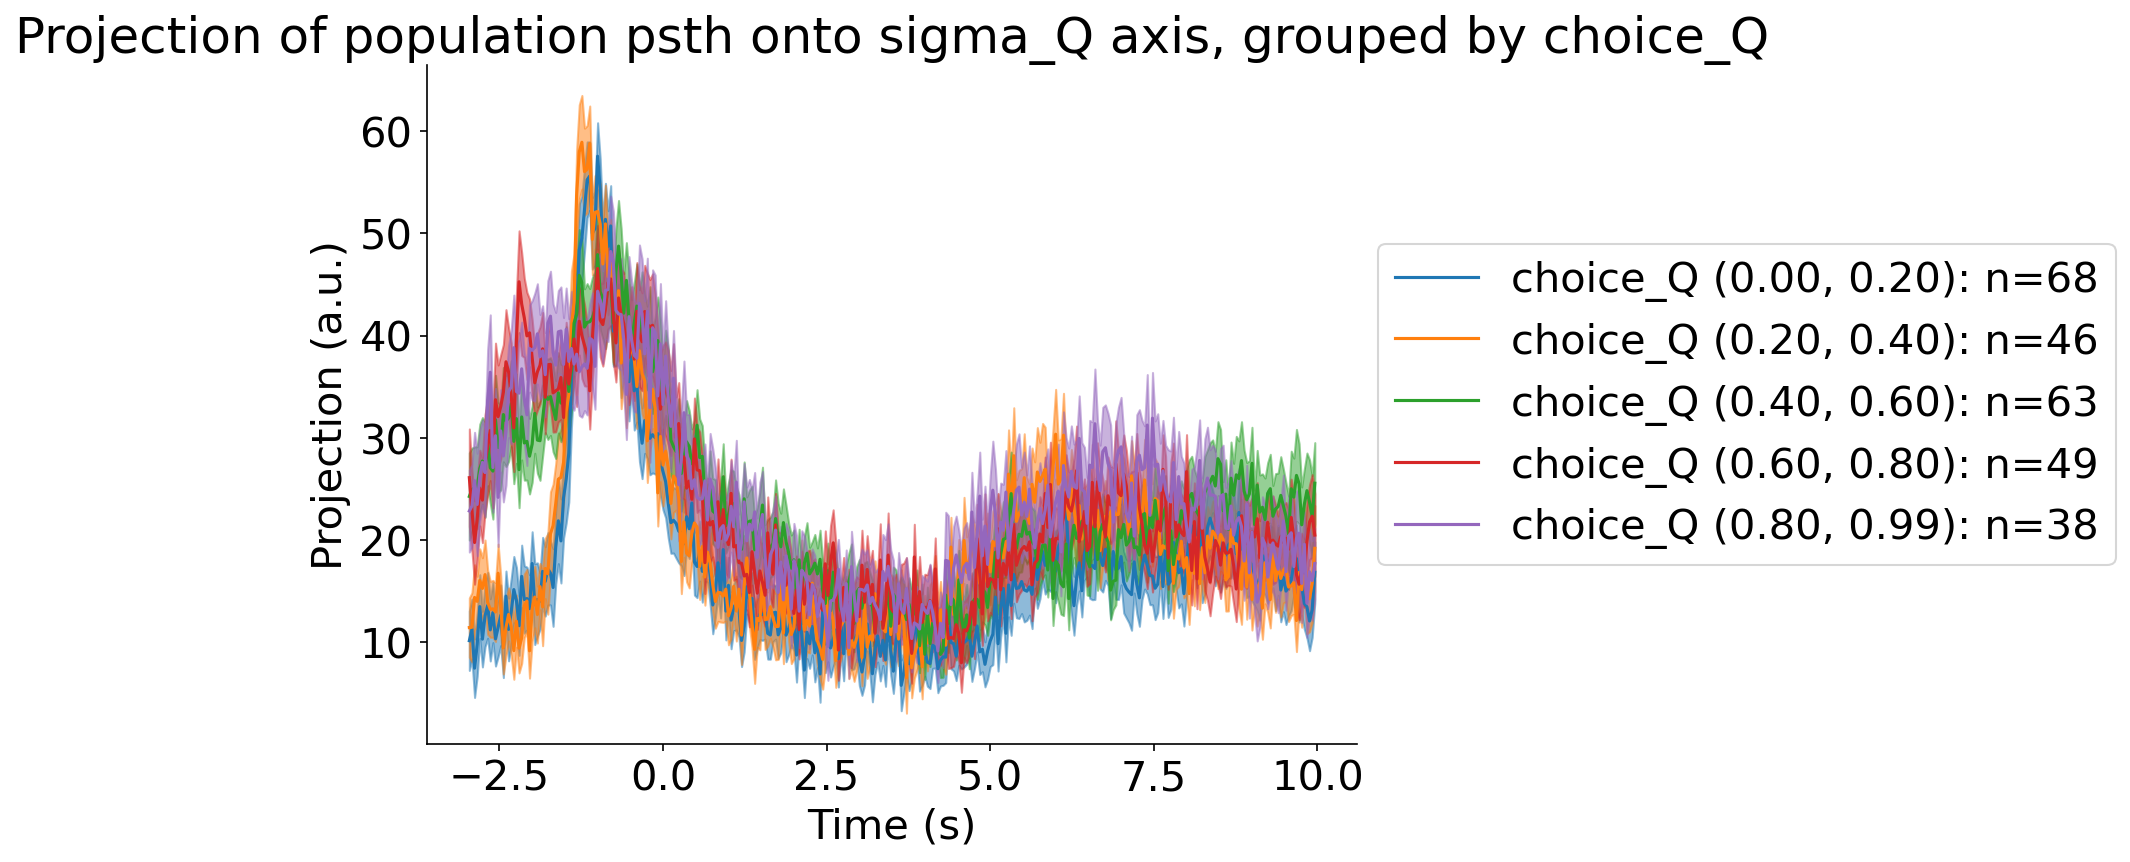

In [45]:
delta_Q_hist, pop_psth_delta_Q_5_div = get_psth_by_target_5_division(delta_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_delta_Q_5_div, ax_targets, delta_Q_hist, 'delta_Q', 'delta_Q')

sigma_Q_hist, pop_psth_sigma_Q_5_div = get_psth_by_target_5_division(sigma_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_sigma_Q_5_div, ax_targets, sigma_Q_hist, 'sigma_Q', 'sigma_Q')

choice_Q_hist, pop_psth_choice_Q_5_div = get_psth_by_target_5_division(choice_Q)
plot_proj_on_axis_by_target_5_division(pop_psth_choice_Q_5_div, ax_targets, choice_Q_hist, 'choice_Q', 'choice_Q')

plot_proj_on_axis_by_target_5_division(pop_psth_delta_Q_5_div, ax_targets, delta_Q_hist, 'delta_Q', 'sigma_Q')
plot_proj_on_axis_by_target_5_division(pop_psth_choice_Q_5_div, ax_targets, choice_Q_hist, 'choice_Q', 'sigma_Q')

In [ ]:
# deprecated
# naive, grouped analysis
proj_avg, proj_sem = get_dspca_axis_projection(pop_psth_all, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg, 'b-')
plt.fill_between(bins, proj_avg-proj_sem, proj_avg+proj_sem,
                alpha=0.5, color='b')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

In [30]:
# deprecated
# quantile analysis

# get quan
sorted_ind_delta_Q = np.argsort(delta_Q)
print(sorted_ind_delta_Q.shape)

n_quantile = int(delta_Q.shape[0]/ 5)
pop_psth_delta_Q_low20 = pop_psth_all[:, sorted_ind_delta_Q[:n_quantile], :]
pop_psth_delta_Q_top20 = pop_psth_all[:, sorted_ind_delta_Q[n_quantile*(-1):], :]

proj_avg_low20, proj_sem_low20 = get_dspca_axis_projection(pop_psth_delta_Q_low20, ax_targets[:, 0])
proj_avg_top20, proj_sem_top20 = get_dspca_axis_projection(pop_psth_delta_Q_top20, ax_targets[:, 0])

fig, axs = plt.subplots(1,1, figsize=(8,6), dpi=150, facecolor='white') 
plt.plot(bins, proj_avg_low20, 'b-', label='low delta Q')
plt.fill_between(bins, proj_avg_low20-proj_sem_low20, proj_avg_low20+proj_sem_low20,
                alpha=0.5, color='b')
plt.plot(bins, proj_avg_top20, 'r-', label='high delta Q')
plt.fill_between(bins, proj_avg_top20-proj_sem_top20, proj_avg_top20+proj_sem_top20,
                alpha=0.5, color='r')
# plt.title('Projection of {}/{} responses onto {} axis'.format(proj_1_source_name, proj_2_source_name, axis_name))
plt.xlabel('Time (s)')
plt.ylabel('Projection (a.u.)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
plt.show()

(408,)


## PCA visualization

In [ ]:
pop_psth_counts = np.average(pop_psth_all, axis=2)

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

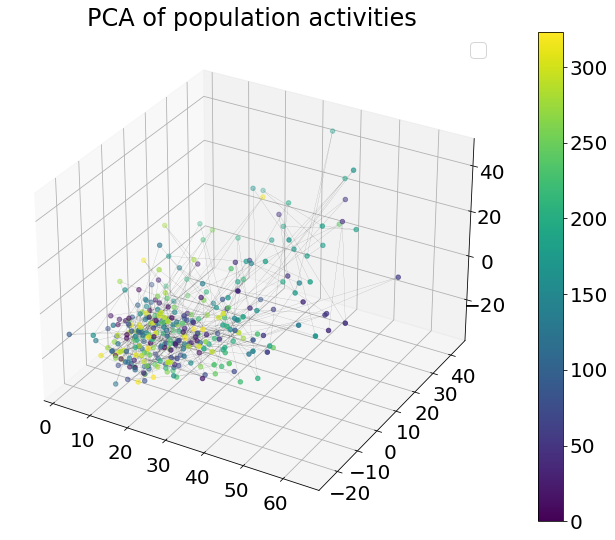

No handles with labels found to put in legend.


[[ 9.91922651e-02  6.67590701e-02  1.62356788e-01 -2.06675148e-01
  -1.44192476e-01 -1.42977177e-01 -3.76197543e-02 -1.24992482e-01
  -4.97484127e-03  2.90411087e-02 -1.45895118e-01  9.54382430e-03
  -7.87630374e-02  2.02146320e-01  3.88571077e-01 -1.26234298e-01
  -4.08270997e-02 -7.02512620e-02  1.06649916e-01 -1.20139437e-01
   6.65525206e-02  2.87402631e-02 -2.85760969e-02 -1.97811503e-01
  -2.49154400e-01  1.55026274e-01 -5.69234943e-02 -9.74524489e-02
   8.05724985e-02  2.59719845e-02  3.27179501e-01 -4.86626231e-02
  -2.00446874e-01  3.03927854e-03 -4.13067144e-02 -1.79707430e-03
  -2.26399539e-02 -1.84327198e-01 -3.38039070e-02 -1.12433622e-01
   3.28827545e-02 -1.56772400e-01 -3.23085860e-01  1.20736865e-02
   1.45455367e-01  1.48192179e-01  8.83799148e-02  8.79146454e-02
   9.38200627e-02 -1.12275881e-01 -1.14359194e-01 -8.27058549e-02
  -4.19705843e-02 -1.36743827e-03 -3.14669974e-03 -3.86185516e-02
  -2.25915414e-02 -7.04539959e-02]
 [-5.24726437e-03 -1.14827765e-03  6.8769

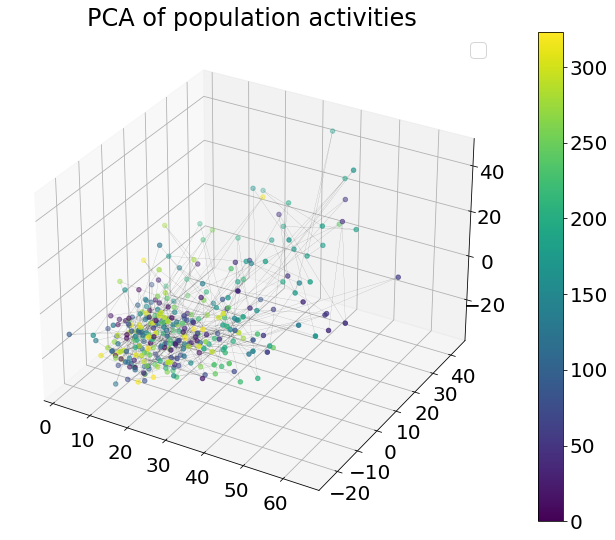

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def pop_counts_pca(pop_psth_avg, cluster_crtieria, verbose=True):
    
    colors = ["navy", "turquoise"]
    lw = 0.01
    
    if cluster_crtieria == 'water_port':
        target_names = ['L', 'R']
        selected_indices = [np.where(np.in1d(all_trial_ind, left_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, right_trial_ind))[0]]
    elif cluster_crtieria == 'outcome':
        target_names = ['hit', 'miss']
        selected_indices = [np.where(np.in1d(all_trial_ind, hit_trial_ind))[0],
                            np.where(np.in1d(all_trial_ind, miss_trial_ind))[0]]
    else:
        raise ValueError('cluster_criteria ill defined')

    pca = PCA(n_components=3)
    X = pop_psth_avg.transpose()   # (trial, units)
    pca.fit(X)
    print(pca.components_)
    print(pca.explained_variance_)
    X_pca = pca.transform(X)     # (trial, n_feature)

    X_pca_all_time = []
    for i in range(pop_psth_all.shape[2]):
        _X_pca = pca.transform(pop_psth_all[:, :, i].transpose())
        X_pca_all_time.append(_X_pca)
    X_pca_all_time = np.array(X_pca_all_time)

    if verbose:
        print('reduced matrix shape: {}'.format(X_pca_all_time.shape))
        print(X_pca_all_time[:, 0, 0])
        # Percentage of variance explained for each components
        print("explained variance ratio (first two components): %s" % str(pca.explained_variance_ratio_))

    fig = plt.figure(figsize=(15,9))
    ax = fig.add_subplot(111, projection='3d')
    # ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)
    t = np.arange(X_pca_all_time.shape[0])

    plot_ind = 9
    p = ax.scatter(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
                   c=t, cmap='viridis')
    ax.plot(X_pca_all_time[:, plot_ind, 0], X_pca_all_time[:, plot_ind, 1], X_pca_all_time[:, plot_ind, 2],
            'k--', lw=0.1)
    
    # for color, ind, target_name in zip(colors, selected_indices, target_names):
    #     ax.scatter(X_pca_all_time[:, ind, 0], X_pca_all_time[:, ind, 1], X_pca_all_time[:, ind, 2],
    #                color=color, alpha=0.8, lw=lw, label=target_name)
    plt.legend(loc="best")
    fig.colorbar(p)
    plt.title("PCA of population activities")
    plt.show()

pop_counts_pca(pop_psth_counts, 'outcome')
pop_counts_pca(pop_psth_counts, 'water_port')